
Total number of glucose readings is: 7676

-------------------------------------------

Combine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...


Total of 171 recorded meals.


A sample (head) of the meals dataframe...

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-08-04 17:41:00  126.0    92.26    23.83        14.78
1 2008-08-05 05:31:00  126.0   194.72    11.59        35.83
2 2008-08-05 07:01:00  103.0     0.00     0.05         0.28
3 2008-08-05 09:56:00  108.0    26.95     0.39         1.29
4 2008-08-05 12:21:00  105.0    70.24     0.61        12.37


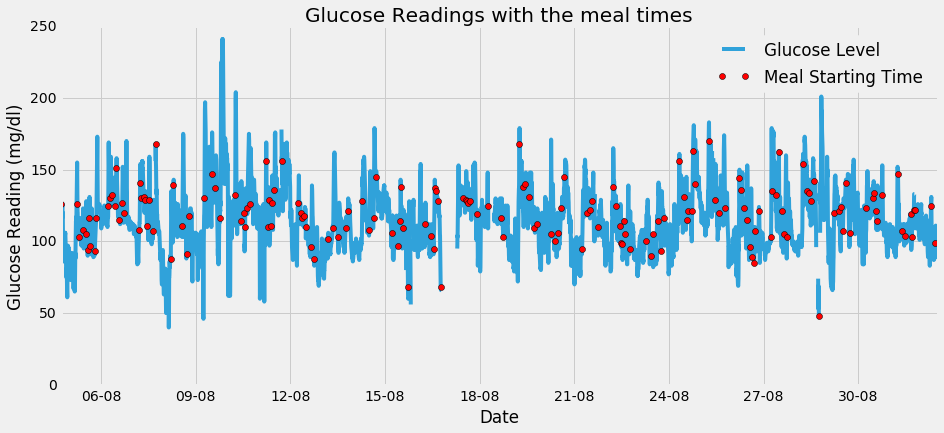

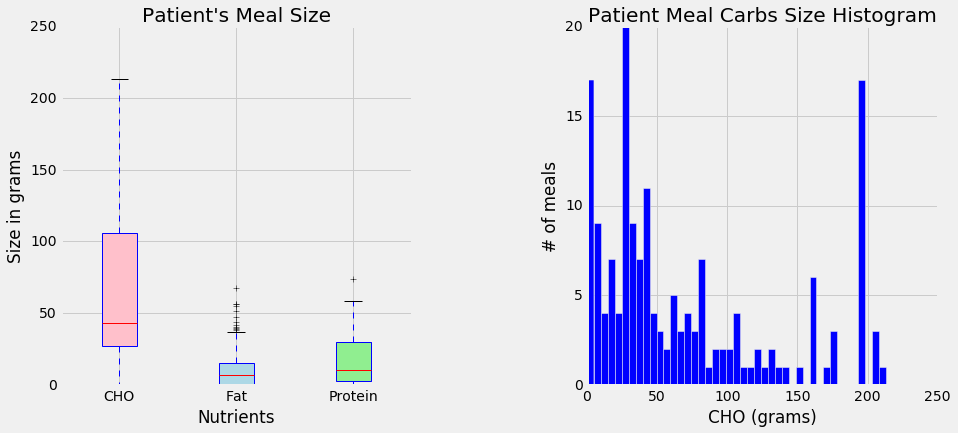



Data Cleaning...


-------------Condition 1-------------------

Remove meal data points with several missing BG readings in their postprandial window...


The meal at 2008-08-07 15:26:00 has 10 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-15 17:21:00 has 6 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-16 18:21:00 has 13 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-18 06:16:00 has 14 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-28 18:01:00 has 7 missing readings within its following 90 minutes. Thus, it will be removed.

The meal at 2008-08-31 18:11:00 has 4 missing readings within its following 90 minutes. Thus, it will be removed.

There are 165 remaining meal recordings.


-------------Condition 2-------------------

Remove meal data points which do NOT have significant BG INCRE

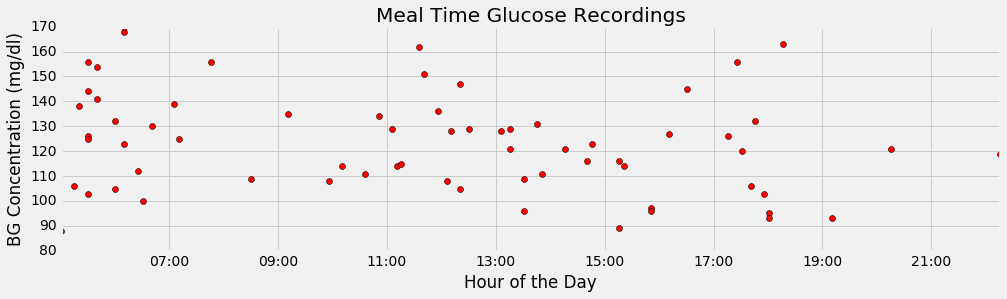

In [477]:
#Run the Data Preprocessing script first!

import warnings
warnings.filterwarnings('ignore')

#use the below couple lines to select which of the preprocessing file to use, comment the others

#%run ./Data_PreProcessing_Set_Mealtime.ipynb
#df_P_meals_w_deletion_v3 = copy.deepcopy(df_P_meals_w_deletion_v2)

%run ./Data_PreProcessing_Adjusted_Mealtime.ipynb
df_P_meals_w_deletion_v3 = copy.deepcopy(increase_pts_df)

In [478]:
#Key variables for this file

least_num_signals_per_inst = 4 #Consider instances with 4 readings or more
signal_duration = 60 #signals must be longer than this duration (minutes) to be accounted for
gl_2nd_increase = 10 #second increase of 10mg/dl, the plot stops if a second increase of this value is detected (mostly happens at next meal)
after_reading = 360 #max size of the plot after meal time in minutes, i.e: up to 10 hours

# Plotting: Actual meal time recordings & Postprandial Signals & Peaks

Plot the full postprandial signal, from meal time until the next significant BG increase past the peak (mostly it is following meal).

In [479]:
#This portion of the code finds the limit of each postprandial signal
stop_plot_date = []

#for x in range(0,2):
for x in range(peak_points_df['Date'].size):#excluding the last meal
    stop = 0
    
    #need to detect when there is a significant increase between current and compared glucose levels
    current_gl_Date = peak_points_df['Date'][x]
    current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
    compared_gl_date = current_gl_Date

    #Here, we check if there is a second BG increase after the peak, if found => stop plot at that point
    for d in drange(0,(after_reading-peak_elapsed_time[x]), 5):
        #print "first point to compare, date:", current_gl_Date, "bg is:", current_gl
        #for l in drange(0, (after_reading-peak_elapsed_time[x]), 5):
        for l in drange(0, 45, 5):
            compared_gl_date += datetime.timedelta(minutes=incr)
            compared_gl = df_P.loc[df_P['Date'] == compared_gl_date]['mg/dL'].values[0]  
            #print "Comparison to second point, date:", compared_gl_date, "bg is:", compared_gl           
            
            #if nan, stop here
            if (math.isnan(compared_gl)):
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(compared_gl_date - datetime.timedelta(minutes=incr))
                break      
            
            if (compared_gl - current_gl > gl_2nd_increase):
                #Find lowest point between current_gl and compared_gl
                lowest2nd_pt = current_gl
                lowest2nd_pt_date = current_gl_Date
                current_gl_temp_date = current_gl_Date
                #print "Enter Loop"
                for s in drange (0,(compared_gl_date - current_gl_Date).seconds / 60,5):
                    current_gl_temp_date += datetime.timedelta(minutes=incr)
                    current_gl_temp = df_P.loc[df_P['Date'] == current_gl_temp_date]['mg/dL'].values[0]
                    #print "current is: date", current_gl_temp_date, "bg is:", current_gl_temp
                    #print "lowest 2n is: date", lowest2nd_pt_date, "bg is:", lowest2nd_pt
                    if (current_gl_temp <= lowest2nd_pt):
                        lowest2nd_pt = current_gl_temp
                        lowest2nd_pt_date = current_gl_temp_date
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                stop_plot_date.append(lowest2nd_pt_date)
                break
        if (stop == 1):
            #print "Stop here", current_gl_Date
            #print "meal,", x
            break
        current_gl_Date += datetime.timedelta(minutes=incr)    
        current_gl = df_P.loc[df_P['Date'] == current_gl_Date]['mg/dL'].values[0] 
    
        compared_gl_date = current_gl_Date    
            
        if (d == after_reading-peak_elapsed_time[x]):
            #print "All the way"
            stop_plot_date.append(current_gl_Date)
            #print "meal,", x

stop_plot_bg_list = [] 

for k in range(len(stop_plot_date)):            
    stop_plot_bg = df_P.loc[df_P['Date'] == stop_plot_date[k]]['mg/dL'].values[0]
    stop_plot_bg_list.append(stop_plot_bg)
#print stop_plot_bg_list


#removing last meal info since it may not have a long enough postprandial signal
#df_P_meals_w_deletion_v3.drop(df_P_meals_w_deletion_v3.index[-1], axis=0,inplace=True)
#print df_P_meals_w_deletion_v3['Date'].size
#print len(stop_plot_date)


The cell above derives the stop points of postprandial signals of all the meals. The stop points are stored in: stop_plot_date 

The cell below creates a dataframe that contains all the points of the postprandial signals for all the meals, from meal time to stop point. The dataframe is: df_all_plots_v2 

In [480]:
Plot_window = [i for i in np.arange(0, after_reading+incr, incr)]

def Plot_extraction_v2(df_P1_w_all_deletion, df_all_plots_v2):
    #print "size is", df_P1_w_all_deletion['Date'].size
    #print "stop plot size is ", len(stop_plot_date)
    for x in range(df_P1_w_all_deletion['Date'].size):
        nancount = 0 #if there are nan readings, stop at the first one
        a = df_P1_w_all_deletion['Date'][x]
        
        #Check if it's last reading, do not consider last meal
        if (x<(df_P1_w_all_deletion['CHO (g)'].size)):              
            b = a
            reading_list = []
            for j in Plot_window:
                reading = df_P.loc[df_P ['Date'] == b]['mg/dL']
                c = stop_plot_date[x]  #Stop at this date because there is another glucose increase right after it       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue

                if (((c - b).total_seconds() < 0)) : 
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue
                else:
                    #store this value on the jth column of xth row of the new dataframe
                    reading_list.append(reading.values[0])
                    b += datetime.timedelta(minutes=incr)
        #print reading_list
        df_all_plots_v2.loc[x]=reading_list
    
    ##If the postprandial signal has many missing points within it, in the middle, remove it
    
    print "Total meals to be plotted are:", df_all_plots_v2.shape[0], "\n"

In [481]:
stop_pt = []
for k in range(len(stop_plot_date)):
    stop_pt.append(((stop_plot_date[k] - df_P_meals_w_deletion_v3['Date'][k]).seconds)/60)

def plotting(df_all_plots_v2, df_P1_w_all_deletion):
    first = True
    plt.figure(figsize=(20,12))
    #for j in range(0,1):
    for j in range(len(df_all_plots_v2)):
        #print df_all_plots_v2.iloc[j]
        #print df_P1_w_all_deletion.iloc[j]
        
        #print peak_points_df['mg/dL'][j]
        row = df_all_plots_v2.iloc[j]
 
        if (first==True):
            #Recorded meal time reading
            plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12, label ='Meal Recordings')
            #Lowest surrounding point of increase
            plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15, label ='Glucose Peaks')
            first = False
            row.plot(label='Meal Time Carbs {} g'.format(round((df_P1_w_all_deletion['CHO (g)'][j]),2)))
            continue
        
        row.plot(label='Meal Time Carbs {} g'.format(round((df_P1_w_all_deletion['CHO (g)'][j]),2)))
        plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=12)
        plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=15)            
        
        #plt.plot(stop_pt[j], stop_plot_bg_list[j], 'b*', markersize=15)
 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Post-meal BG variation of Different Meals'.format(after_reading)
    plt.title(title);

    #Uncomment below to save plot
    #plt.savefig('Patient_1_Plotsaftermeal_iter0to5.png')

Total meals to be plotted are: 67 



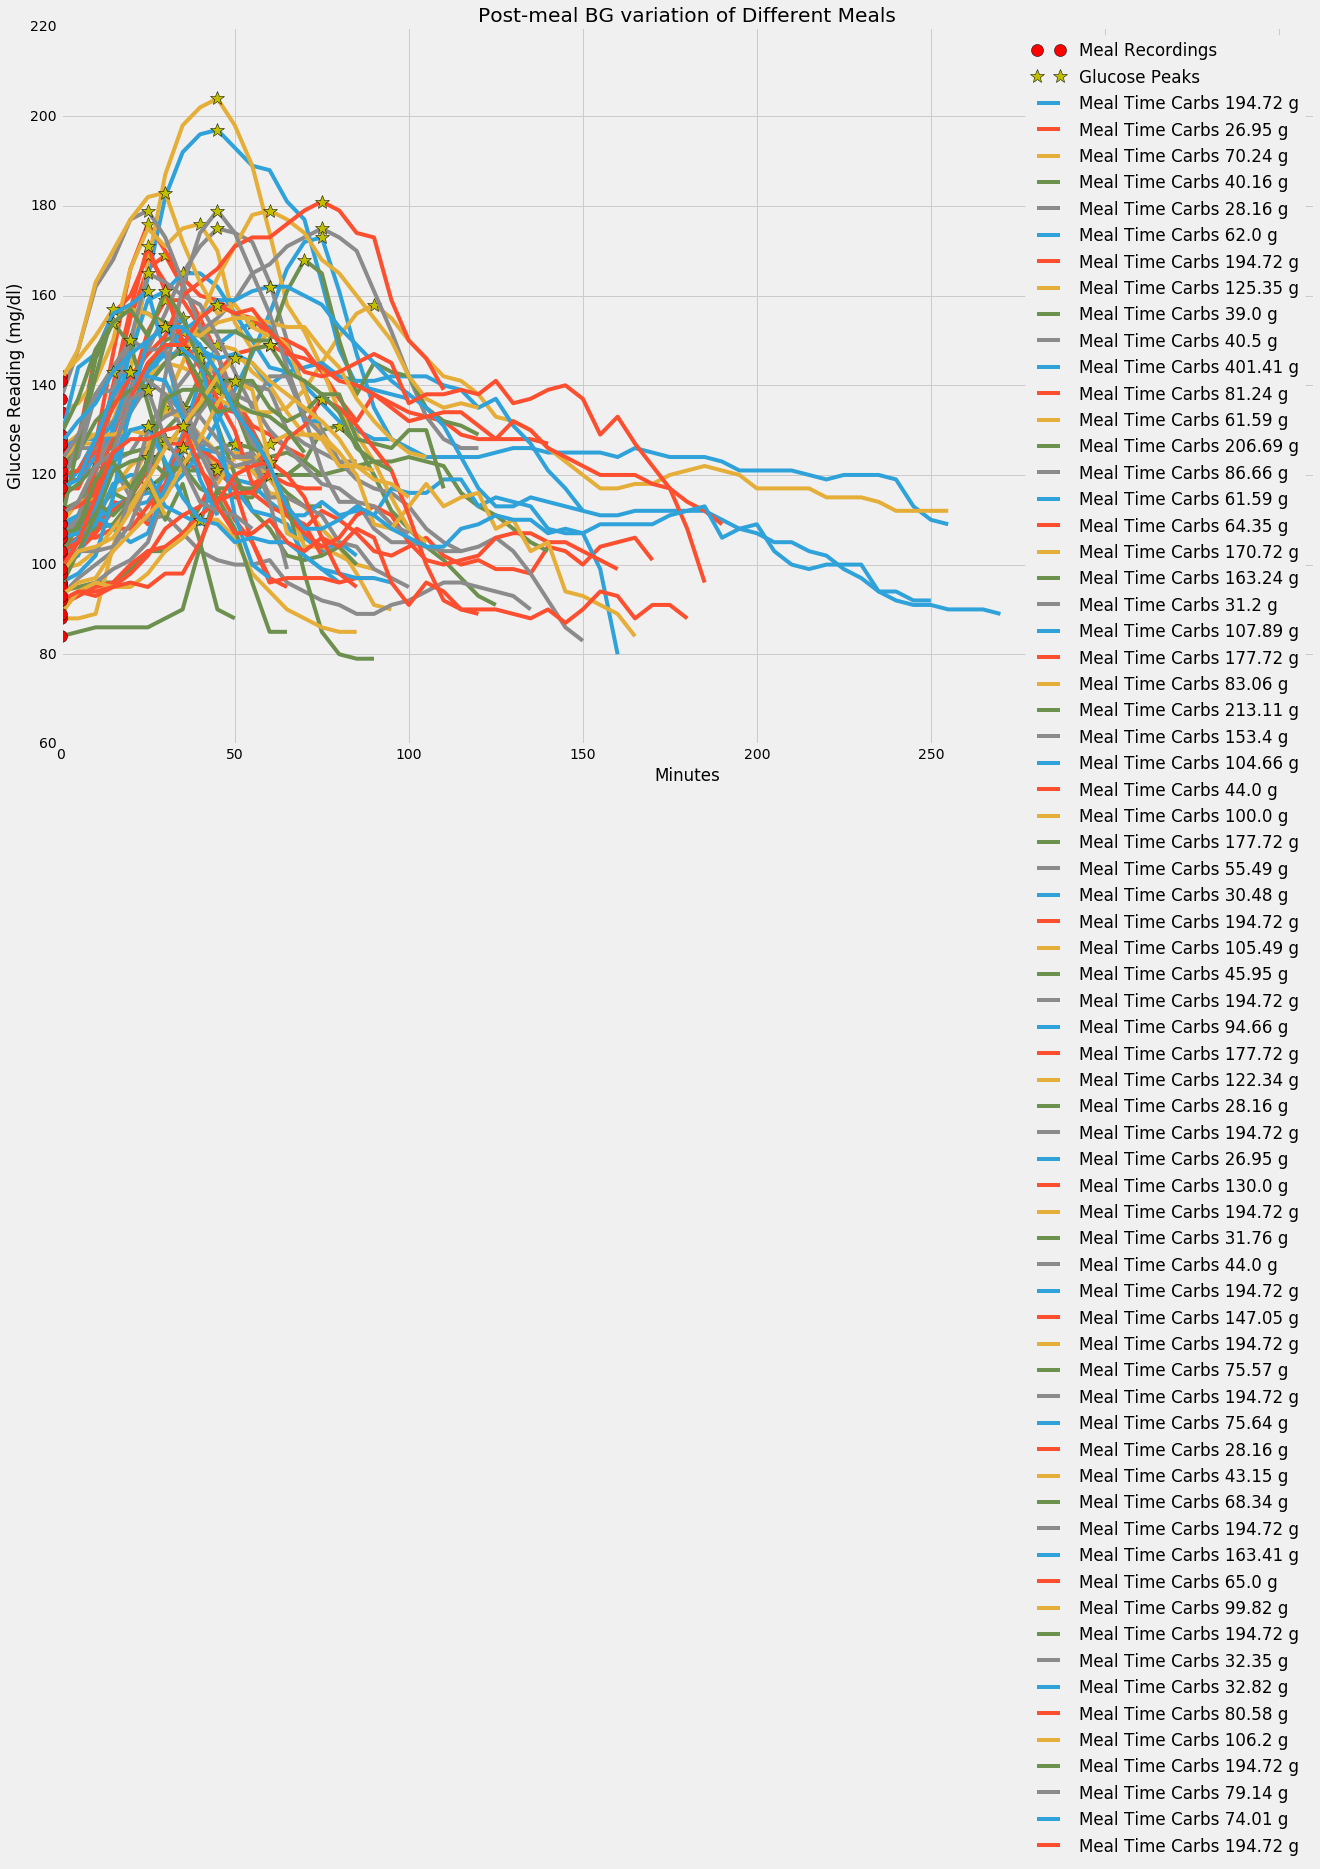

In [482]:
df_all_plots_v2 = pd.DataFrame(columns=Plot_window)

#df_all_plots_v2: contains the full postprandial signals for all meals
#df_P_meals_w_deletion_v3: contains the meal time readings and their info

Plot_extraction_v2(df_P_meals_w_deletion_v3, df_all_plots_v2)
plotting(df_all_plots_v2, df_P_meals_w_deletion_v3)

#print "size of df containing meals is:", df_P_meals_w_deletion_v3.shape[0]
#print "size of df containing plots of all meals is:", df_all_plots_v2.shape[0]

### Remove plots which have a duration less than 60 minutes

In [483]:
#print_full(all_signals_df_cleaned)
#print all_signals_df_cleaned.shape[0]

print df_all_plots_v2.shape[0]

def remove_short_signals(period_signals):
    #Detect first NaN occurance on the signal, if less than 90 minutes remove that signal
    global signal_incomplete
    signal_incomplete = []
    for j in range(period_signals.shape[0]):
        #print "j is:", j 
        #print period_signals.iloc[j]
        out = np.argwhere(np.isnan(period_signals.iloc[j]))
        try:
            out[0][0]
        except IndexError:
            #print "full signal, no NAN"   
            continue   
        #print out[0][0]
        #print "j is:", out[0]
        if ((out[0][0]*5) < signal_duration): #if signal is less than 90 minutes
            signal_incomplete.extend([j])

remove_short_signals(df_all_plots_v2)  

#print signal_incomplete  
print len(signal_incomplete), "signals are removed from all postprandial signals.\n"
df_all_plots_v2.drop(df_all_plots_v2.index[signal_incomplete], axis=0,inplace=True)
df_all_plots_v2 = df_all_plots_v2.reset_index(drop=True)

print "Total remaining meals are:", df_all_plots_v2.shape[0]


67
6 signals are removed from all postprandial signals.

Total remaining meals are: 61


### Remove those signals from other dataframes and series as well

In [484]:
peak_elapsed_time = np.delete(peak_elapsed_time, signal_incomplete, axis=0)

peak_points_df.drop(peak_points_df.index[signal_incomplete], axis=0,inplace=True)
peak_points_df = peak_points_df.reset_index(drop=True)

df_P_meals_w_deletion_v3.drop(df_P_meals_w_deletion_v3.index[signal_incomplete], axis=0,inplace=True)
df_P_meals_w_deletion_v3 = df_P_meals_w_deletion_v3.reset_index(drop=True)

# print peak_elapsed_time.size
# print peak_points_df.shape[0]
# print df_P_meals_w_deletion_v3.shape[0]

## Alignment of the signals

In [485]:
from sklearn import preprocessing

def alignmentandnormalization(df_period_plots):

    global signals_normalized_df 
    signals_normalized_df = copy.deepcopy(df_period_plots)
    global signals_aligned_df 
    signals_aligned_df = copy.deepcopy(df_period_plots)
    
    signalsdf_wo_nan = pd.DataFrame()

   
    for j in range(len(df_period_plots)):

        signal_wo_nan = df_period_plots.iloc[j][~np.isnan(df_period_plots.iloc[j])]
        aligned_signal = [x - df_period_plots.iloc[j,0] for x in signal_wo_nan]

        signals_aligned_df.iloc[j,0:len(aligned_signal)] = aligned_signal 
        signals_aligned_df.iloc[j,len(aligned_signal):df_period_plots.shape[1]] = np.nan


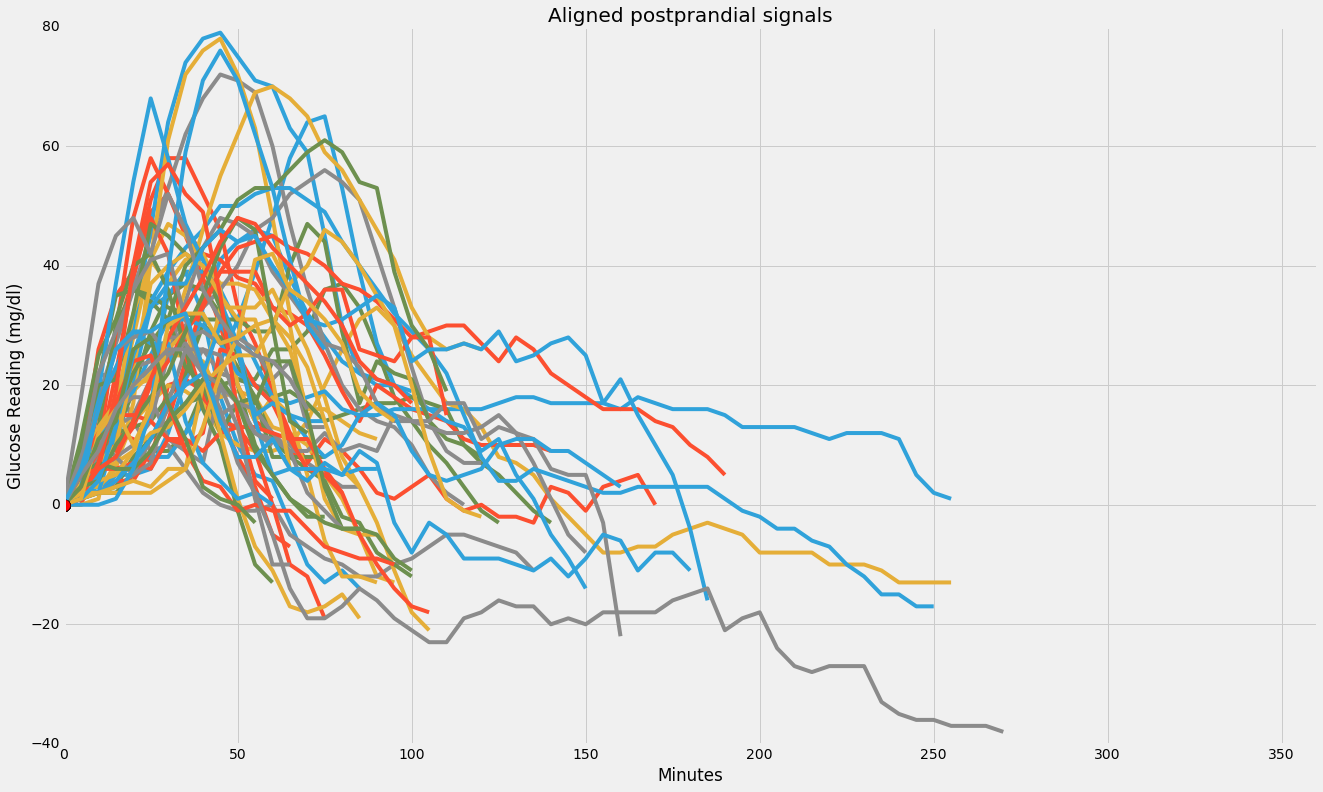

In [486]:
#alignmentandnormalization(df_all_plots_v2)
import warnings
warnings.filterwarnings('ignore') 

def plotsaligned(periodmeals, full_postprandials):
    #print "\nPostprandial signals aligned...\n"
    
    alignmentandnormalization(full_postprandials)
    
    plt.figure(figsize=(20,12))

    #for j in range(1,20):
    for j in range(len(signals_aligned_df)):
        #print df_all_plots_v2.iloc[j]
        row = signals_aligned_df.iloc[j]
        #if (round((df_P_meals_w_deletion_v3['CHO (g)'][j]),2) < 35):
        row.plot(label = '')
        #row.plot(label='Meal Time Carbs {} g'.format(round((periodmeals['CHO (g)'][j]),2)))
        plt.plot(0, signals_aligned_df[0][j], 'ro', markersize=12)     


    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Aligned postprandial signals'
    plt.title(title);
    
plotsaligned(df_P_meals_w_deletion_v3, df_all_plots_v2)   

all_meal_bg = df_all_plots_v2.iloc[:,0].values


## Dividing the day into Breakfast, Lunch, Dinner

In [487]:
df_all_clean_1day = copy.deepcopy(df_P_meals_w_deletion_v3)#actual meals, and not the increase points

d = datetime.datetime.today()
for i in range(len(df_all_clean_1day)):
    dt = df_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_all_clean_1day.Date[i] = dt

#output to static HTML file
output_file("Aggregated_Meal_Recordings.html")

plot = figure(plot_width=1250, plot_height=600, title="Meal Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

good_readings = ColumnDataSource(dict(x=df_all_clean_1day.Date, y=df_all_clean_1day['mg/dL'], z=df_all_clean_1day['CHO (g)'], k = df_all_clean_1day['Fat (g)'], d = df_all_clean_1day['Protein (g)']))

g1 = plot.asterisk(x=df_all_clean_1day.Date, y=df_all_clean_1day['mg/dL'], line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Hour of the Day"
plot.yaxis.axis_label = "BG Concentration (mg/dL)"

show(plot)

In [488]:
#The three main data sets are below:

All_periods_df = copy.deepcopy(df_all_plots_v2)
breakfast_df = copy.deepcopy(df_all_plots_v2)
lunch_df = copy.deepcopy(df_all_plots_v2)
dinner_df = copy.deepcopy(df_all_plots_v2)

peak_elapsed_breakfast = copy.deepcopy(peak_elapsed_time)
peak_elapsed_lunch = copy.deepcopy(peak_elapsed_time)
peak_elapsed_dinner = copy.deepcopy(peak_elapsed_time)

breakfast_peak_df = copy.deepcopy(peak_points_df)
lunch_peak_df = copy.deepcopy(peak_points_df)
dinner_peak_df = copy.deepcopy(peak_points_df)

breakfast_start_hour = 5
breakfast_max_hour = 10

lunch_start_hour = 11
lunch_max_hour = 15

#snack_start_hour = 14
#snack_max_hour = 16

dinner_start_hour = 16
dinner_max_hour = 23

remove_from_breakfast_x = []
remove_from_lunch_x = []
remove_from_dinner_x = []

keep_breakfast_x = []
keep_lunch_x = []
keep_dinner_x =[]
keep_x = []

for x in range(len(df_P_meals_w_deletion_v3)):
    a = df_P_meals_w_deletion_v3['Date'][x]
    meal_Date = df_P.loc[df_P['Date'] == a]['Date']
    meal_dt=meal_Date.values[0]
    mdt = datetime.datetime.utcfromtimestamp(meal_dt.astype('O')/(1e9))
    #print mdt.strftime('%H:%M:%S')
    meal_hr = mdt.strftime('%H')    
    #print int(meal_hr)
    if (int(meal_hr)>breakfast_max_hour or int(meal_hr)<breakfast_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        remove_from_breakfast_x.append(x)
    else:    
        keep_breakfast_x.append(x)
        
    if (int(meal_hr)>lunch_max_hour or int(meal_hr)<lunch_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period  
        remove_from_lunch_x.append(x)
    else:    
        keep_lunch_x.append(x)
    
    if (int(meal_hr)>dinner_max_hour or int(meal_hr)<dinner_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        remove_from_dinner_x.append(x)
    else:    
        keep_dinner_x.append(x)
    
    keep_x.append(x)
#print remove_from_breakfast_x
#print keep_breakfast_x
        
###############Breakfast
breakfast_df.drop(breakfast_df.index[remove_from_breakfast_x],axis=0,inplace=True)
breakfast_df = breakfast_df.reset_index(drop=True)  
print "This patient has", len(breakfast_df), "breakfast readings.\n"
#print "The indeces of breakfast within the full dataframe are:", keep_breakfast_x

breakfast_peak_df.drop(breakfast_peak_df.index[remove_from_breakfast_x],axis=0,inplace=True)
breakfast_peak_df = breakfast_peak_df.reset_index(drop=True)

peak_elapsed_breakfast = np.delete(peak_elapsed_breakfast, remove_from_breakfast_x)

###############Lunch
lunch_df.drop(lunch_df.index[remove_from_lunch_x],axis=0,inplace=True)
lunch_df = lunch_df.reset_index(drop=True)  
print "This patient has", len(lunch_df), "lunch readings.\n"
#print "The indeces of lunch within the full dataframe are:", keep_lunch_x


lunch_peak_df.drop(lunch_peak_df.index[remove_from_lunch_x],axis=0,inplace=True)
lunch_peak_df = lunch_peak_df.reset_index(drop=True)

peak_elapsed_lunch = np.delete(peak_elapsed_lunch, remove_from_lunch_x)


###############Dinner
dinner_df.drop(dinner_df.index[remove_from_dinner_x],axis=0,inplace=True)
dinner_df = dinner_df.reset_index(drop=True) 
print "This patient has", len(dinner_df), "dinner readings.\n"
#print "The indeces of dinner within the full dataframe are:", keep_dinner_x

dinner_peak_df.drop(dinner_peak_df.index[remove_from_dinner_x],axis=0,inplace=True)
dinner_peak_df = dinner_peak_df.reset_index(drop=True)

peak_elapsed_dinner = np.delete(peak_elapsed_dinner, remove_from_dinner_x)
    
#dinner_df.to_csv('Patient1_dinner_df.csv', sep='\t', encoding='utf-8')
#dinner_df.to_csv('Patient_dinner_df.csv', index=False)
#lunch_df.to_csv('Patient_lunch_df.csv', index=False)
#breakfast_df.to_csv('Patient_breakfast_df.csv', index=False)
    
all_breakfast_df = pd.DataFrame()
all_lunch_df = pd.DataFrame() 
all_dinner_df = pd.DataFrame()
all_combined_df = pd.DataFrame()

def period_meals_list(kept_period_meals):
    df_period_meals = pd.DataFrame()
    for k in range(len(kept_period_meals)):
        df_period_meals[k] = df_P_meals_w_deletion_v3.iloc[kept_period_meals[k]]    
    
    meals_df = copy.deepcopy(df_period_meals.T)
    #print  meals_df
    return meals_df

#print "This patient has the recorded the following meals for breakfast:"
all_breakfast_df = period_meals_list(keep_breakfast_x)

#print all_breakfast_df

#print "This patient has the recorded the following meals for lunch:"
all_lunch_df = period_meals_list(keep_lunch_x)

#print "This patient has the recorded the following meals for dinner:"
all_dinner_df = period_meals_list(keep_dinner_x)

all_combined_df = period_meals_list(keep_x)
#print all_combined_df

This patient has 22 breakfast readings.

This patient has 24 lunch readings.

This patient has 14 dinner readings.



In [489]:
def Plot_Period(period_to_plot, peaks_df, peaks_offset):

    period_df = copy.deepcopy(period_to_plot)
    peak_pts_df = copy.deepcopy(peaks_df)
    peak_elapsed_t = copy.deepcopy(peaks_offset)
    
    plt.figure(figsize=(20,12))
    #for j in range(0,5):
    for j in range(len(period_df)):
        row = period_df.iloc[j]
        row.plot()
        #row.plot(label='Meal Time at {}'.format(df_P1_w_all_deletion['Date'][j]))
        #Recorded meal time reading
        plt.plot(0, period_df[0][j], 'ro', markersize=10)
        plt.plot(peak_elapsed_t[j], peak_pts_df['mg/dL'][j], 'y*', markersize=20) 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    #plt.legend(loc='upper right')
    title = 'Glucose Lelvel Readings {} minutes after meal recording or until next meal recording'.format(after_reading)
    plt.title(title)

    plt.show()

Plotting of segmented after meal plots for Breakfast


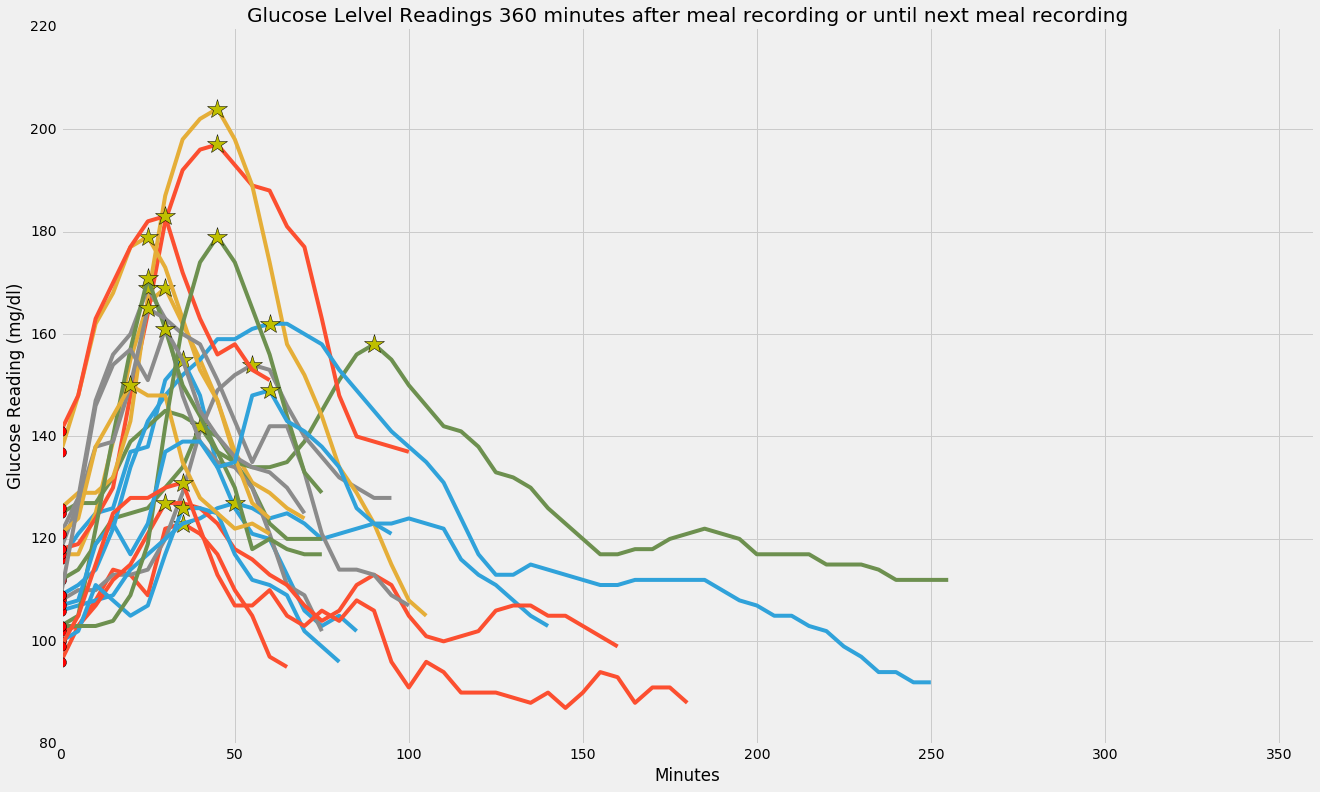

Plotting of segmented after meal plots for Lunch


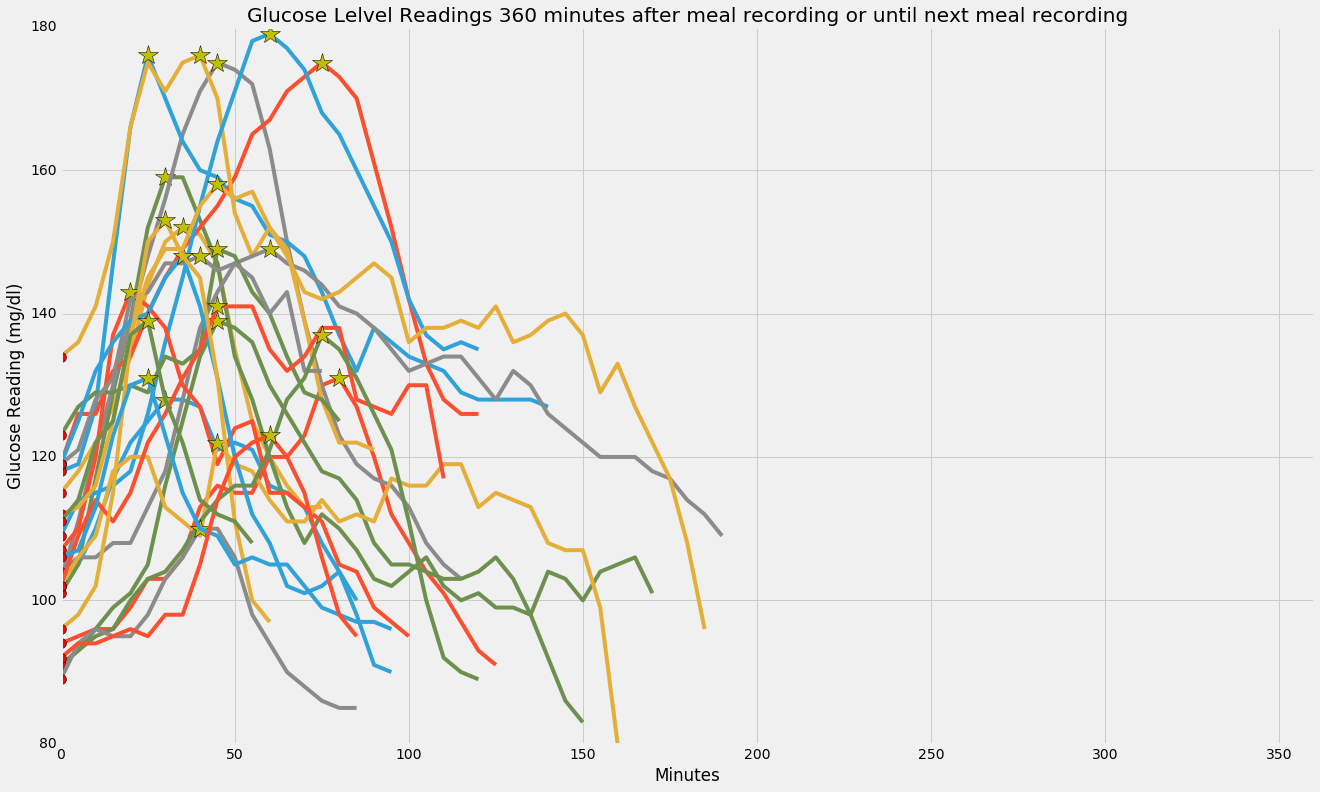

Plotting of segmented after meal plots for Dinner


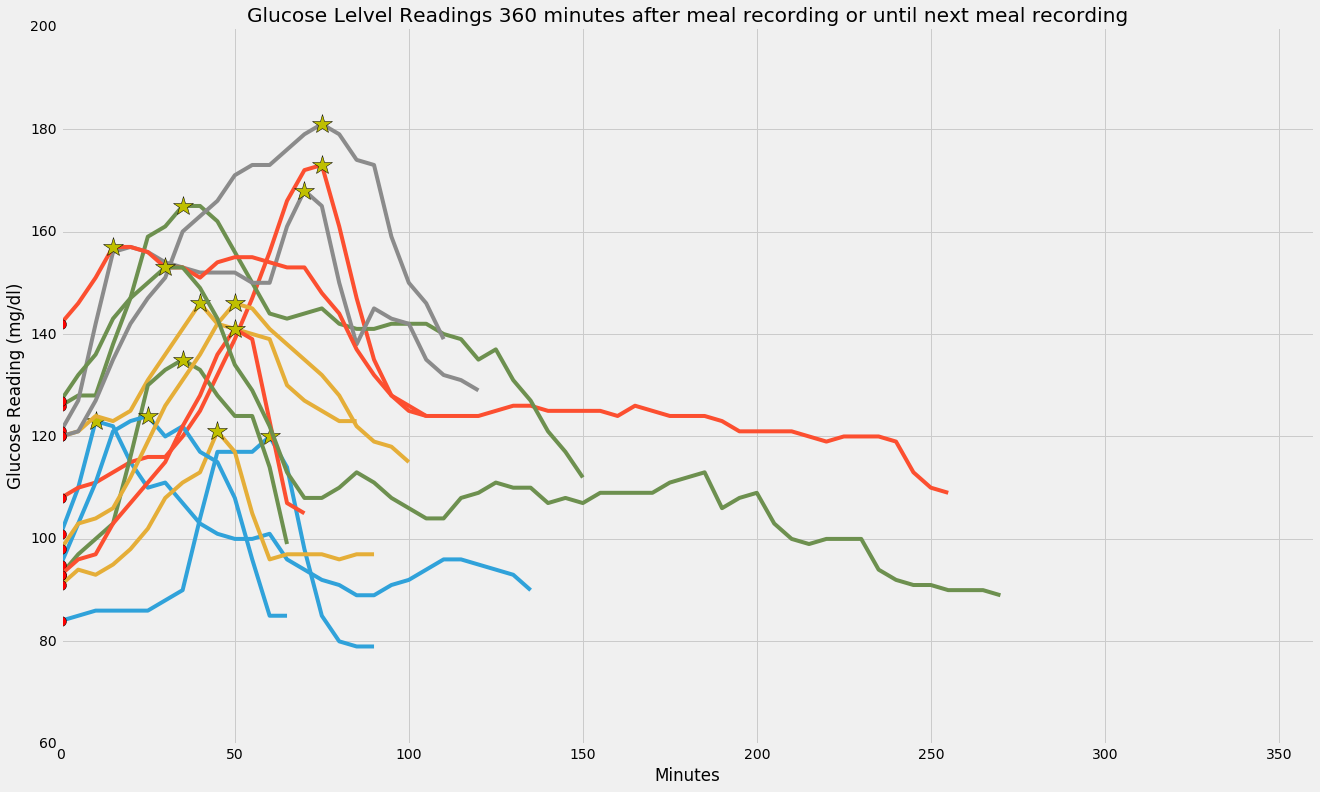

In [490]:
#Plot any preriod by replacing period_df by the desired period,
#arg1 is breakfast_df or lunch_df or dinner_df
#arg2 is breakfast_peak_df, lunch_peak_df, dinner_peak_df
#arg3 is peak_elapsed_breakfast, peak_elapsed_lunch, peak_elapsed_dinner

print "Plotting of segmented after meal plots for Breakfast"
Plot_Period(breakfast_df, breakfast_peak_df, peak_elapsed_breakfast)
breakfast_meal_bg = breakfast_df.iloc[:,0].values

print "Plotting of segmented after meal plots for Lunch"
Plot_Period(lunch_df, lunch_peak_df, peak_elapsed_lunch)
lunch_meal_bg = lunch_df.iloc[:,0].values

print "Plotting of segmented after meal plots for Dinner"
Plot_Period(dinner_df, dinner_peak_df, peak_elapsed_dinner)
dinner_meal_bg = dinner_df.iloc[:,0].values

**Plotting aligned plots for each period respectively**


Plotting aligned postprandial signals for breakfast, lunch, dinner, respectively...


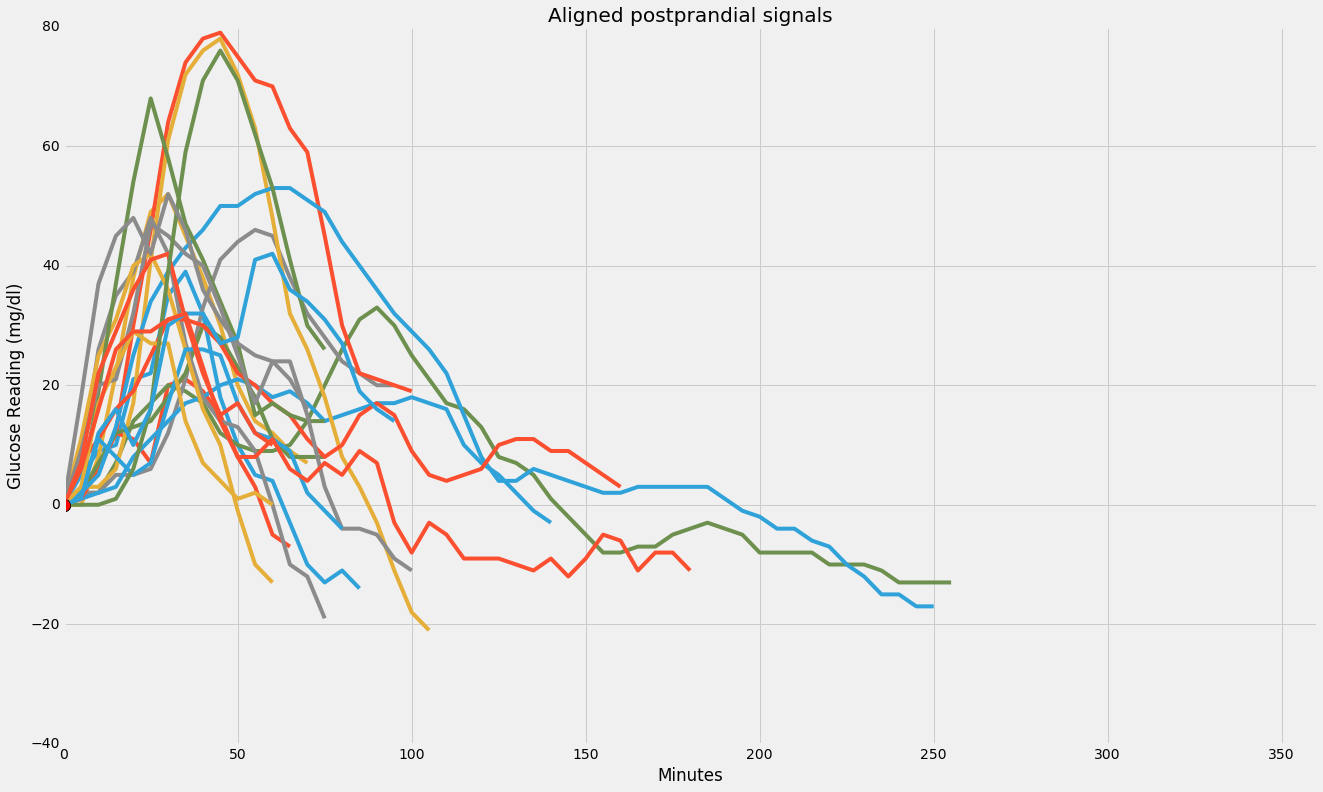

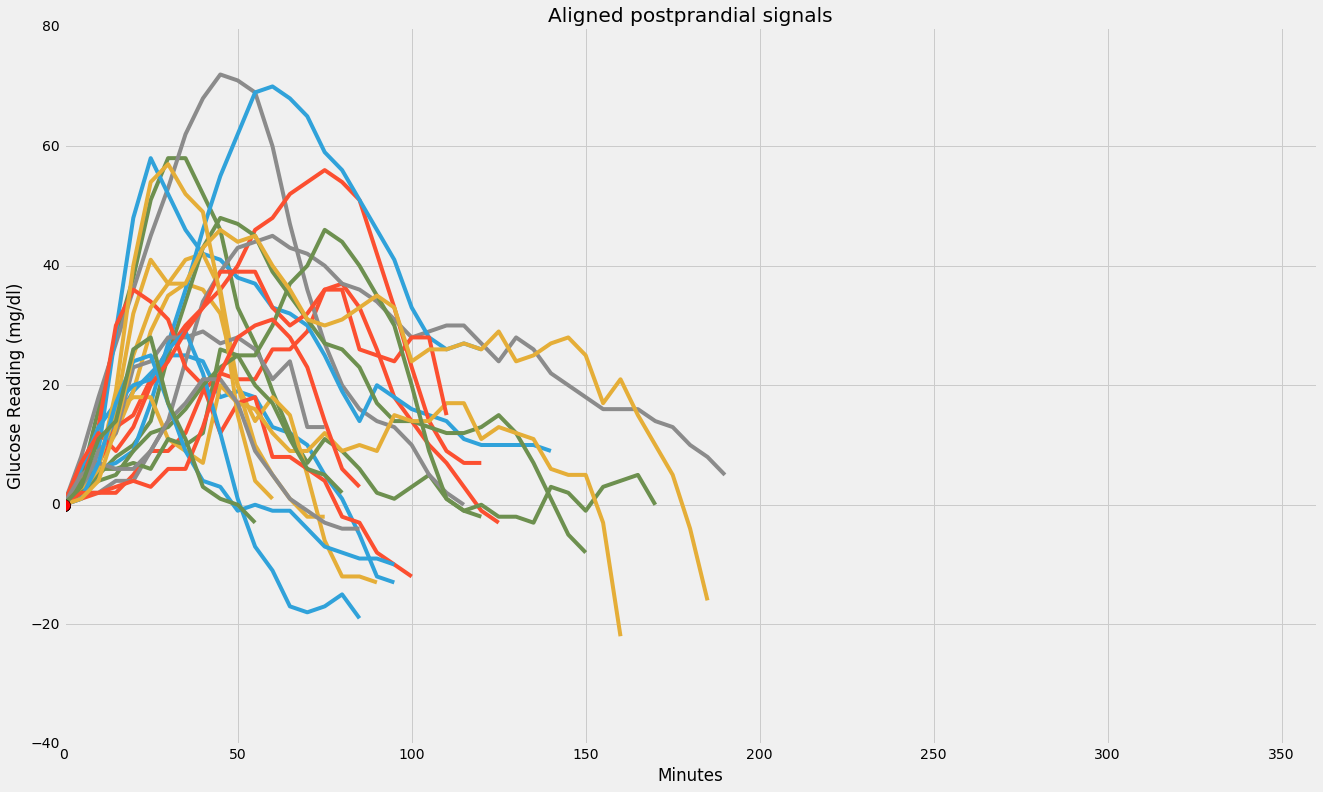

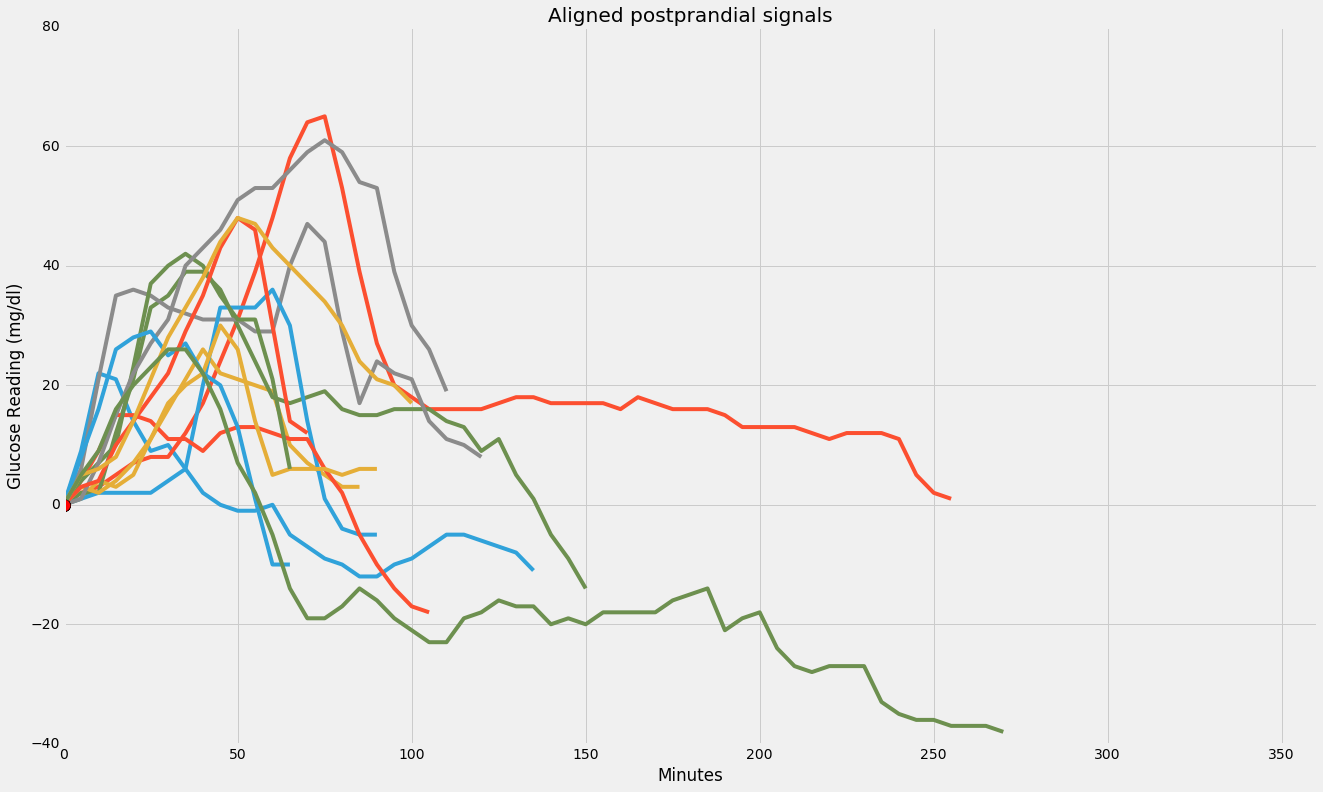

In [491]:
print "\nPlotting aligned postprandial signals for breakfast, lunch, dinner, respectively...\n", 
plotsaligned(all_breakfast_df, breakfast_df)#outputs aligned signals only
#plotsnormalized(all_breakfast_df, breakfast_df)#This outputs normalized signals of the aligned signals
  
#breakfast_signals_df = copy.deepcopy(signals_normalized_df)#this is for normalized output signals
breakfast_signals_df = copy.deepcopy(signals_aligned_df)#this is for aligned only output signals

plotsaligned(all_lunch_df, lunch_df)
#plotsnormalized(all_lunch_df, lunch_df)
  
lunch_signals_df = copy.deepcopy(signals_aligned_df)

plotsaligned(all_dinner_df, dinner_df)
#plotsnormalized(all_dinner_df, dinner_df)
   
dinner_signals_df = copy.deepcopy(signals_aligned_df)

### All postprandial signals combined

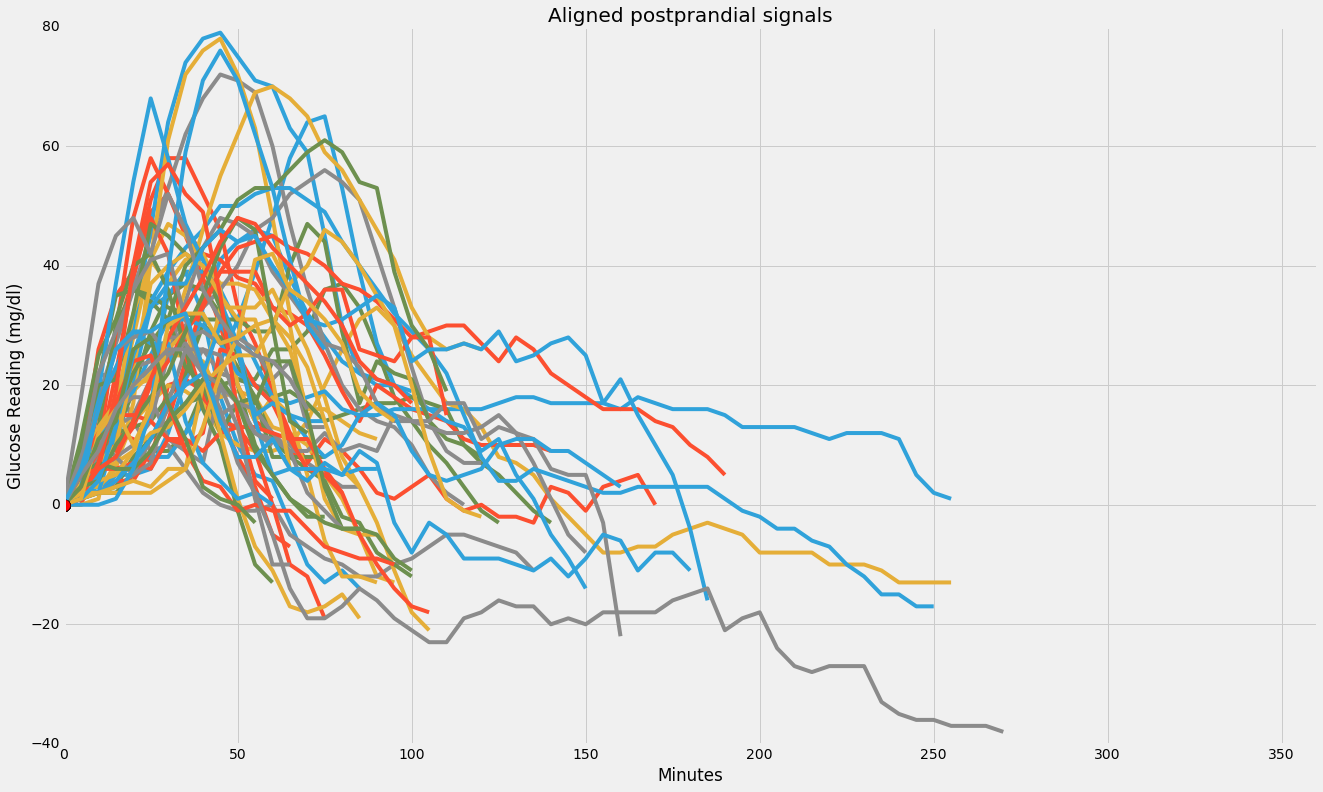

In [492]:
plotsaligned(all_combined_df, All_periods_df)
all_signals_df = copy.deepcopy(signals_aligned_df)

**Average of the aligned signals for each of the periods**

### Remove signals with extreme outliers from each of the prandial periods

In [493]:
#print_full(breakfast_signals_df)

#Replace time instances with several nan BG concentrations with full column of nan, so it is not biased to specific signals
def replacenansignals(period_signal_df):

    for k in range(period_signal_df.shape[1]):
        #print breakfast_signals_df[breakfast_signals_df.columns[k]]
        xaxis_size =  period_signal_df.shape[0]
        total_nan = sum(pd.isnull(period_signal_df[period_signal_df.columns[k]]))
        available_readings = xaxis_size - total_nan
        #print available_readings

        if (available_readings < least_num_signals_per_inst):#if there are less than 4 signals at some time instance, don't consider them. Only if more than 3
            period_signal_df[period_signal_df.columns[k]] = np.nan
        #print period_signal_df[period_signal_df.columns[k]]     

print "Breakfast, checking for sufficient data points in the signal..."        
replacenansignals(breakfast_signals_df)
print "Lunch, checking for sufficient data points in the signal..." 
replacenansignals(lunch_signals_df)
print "Dinner, checking for sufficient data points in the signal..." 
replacenansignals(dinner_signals_df)  

replacenansignals(all_signals_df) 

Breakfast, checking for sufficient data points in the signal...
Lunch, checking for sufficient data points in the signal...
Dinner, checking for sufficient data points in the signal...


**Remove outlier signals, which have significant differences than others**

Steps:
1. Find 95% and 5% percentile at each time increment
2. If a signal falls several times outside the 95% and 5%, more than 5 times i.e, remove it

In [494]:
import scipy.stats as st

def get_percentile(period_df):
    global signal_upper_p 
    signal_upper_p = []
    global signal_lower_p
    signal_lower_p = []

    for k in range(period_df.shape[1]):
        temp_signal = []
        temp_signal = period_df.iloc[:,k][~np.isnan(period_df.iloc[:,k])]

        #print "length of signal is:", len(temp_signal), "and its content is: \n", temp_signal
        
        if (len(temp_signal) >= least_num_signals_per_inst):
            #95%percentile
            upper_p = np.percentile(temp_signal, 97.5)
            lower_p = np.percentile(temp_signal, 2.5)

            #print "upper p is:", upper_p, "and lower p is:", lower_p
            signal_upper_p.append(upper_p)
            signal_lower_p.append(lower_p)
    #return signal_upper_p, signal_lower_p

get_percentile(lunch_signals_df)

#print "Upper percentile: \n", signal_upper_p
#print "Lower percentile: \n", signal_lower_p
################

In [495]:
#Count the signals that have values outside the percentiles, if many then remove

def get_extreme_outliers(period_df):
    print "The size of the percentile array for this period is:", len(signal_upper_p)
    print "\nThe period contains the following number of signals:", period_df.shape[0], "\n"
    global extreme_outliers
    extreme_outliers = []
    for k in range(period_df.shape[0]):
        count = 0
        comparisons_pts = 0
        for i, item in enumerate(period_df.iloc[k]):
            if (i<len(signal_lower_p)  and (~math.isnan(item))):
                comparisons_pts += 1
                if ((item < signal_lower_p[i] or item > signal_upper_p[i])):
                    count += 1

        #print "The signal", k, "has", count , "extreme outliers out of", comparisons_pts,"points.\n"
      
        #condition to remove signals which are extreme and very rare, have over half (or one fourth) of their points outside the 95% percentile of the rest of signal points
        if (count>(comparisons_pts/3)):            
            extreme_outliers.append(k)
    print "The following signals are considered abnormal for having extreme outliers over the full signal spectrum:", extreme_outliers

#save the original period dataframes before removing the outliers
breakfast_org_df = copy.deepcopy(breakfast_signals_df)
lunch_org_df = copy.deepcopy(lunch_signals_df)
dinner_org_df = copy.deepcopy(dinner_signals_df)

#Breakfast
get_percentile(breakfast_signals_df)
print "\nRemove any abnormal signals from BREAKFAST period if they have several extreme outliers..."    
get_extreme_outliers(breakfast_signals_df)

breakfast_signals_df.drop(breakfast_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining breakfast signals are:", breakfast_signals_df.shape[0]
#Breakfast Dataframe with dates and meal info
#print "Size of breakfast df containing dates is:", all_breakfast_df.shape[0]
#all_breakfast_df.drop(all_breakfast_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of breakfast df containing dates is:", all_breakfast_df.shape[0]

#Remove extreme outliers from the arrays containing preprandial bg levels
breakfast_preprandial_bg = np.delete(breakfast_meal_bg, extreme_outliers, axis=0)
print "\nThe preprandial BG Mean for remaining Breakfast meals is:", round(np.mean(breakfast_preprandial_bg),2),"mg/dl"

#Lunch
get_percentile(lunch_signals_df)
print "\n\nRemove any abnormal signals from LUNCH period if they have several extreme outliers..." 
get_extreme_outliers(lunch_signals_df)
lunch_signals_df.drop(lunch_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining lunch signals are:", lunch_signals_df.shape[0]
#Lunch Dataframe with dates and meal info
#print "Size of lunch df containing dates is:", all_lunch_df.shape[0]
#all_lunch_df.drop(all_lunch_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of lunch df containing dates is:", all_lunch_df.shape[0]

#Remove extreme outliers from the arrays containing preprandial bg levels
lunch_preprandial_bg = np.delete(lunch_meal_bg, extreme_outliers, axis=0)
print "\nThe preprandial BG Mean for remaining Lunch meals is:", round(np.mean(lunch_preprandial_bg),2),"mg/dl"

#Dinner
get_percentile(dinner_signals_df)
print "\n\nRemove any abnormal signals from DINNER period if they have several extreme outliers..."     
get_extreme_outliers(dinner_signals_df) 
dinner_signals_df.drop(dinner_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining dinner signals are:", dinner_signals_df.shape[0]
#Dinner Dataframe with dates and meal info
#print "Size of dinner df containing dates is:", all_dinner_df.shape[0]
#all_dinner_df.drop(all_dinner_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of dinner df containing dates is:", all_dinner_df.shape[0]    

#Remove extreme outliers from the arrays containing preprandial bg levels
dinner_preprandial_bg = np.delete(dinner_meal_bg, extreme_outliers, axis=0)
print "\nThe preprandial BG Mean for remaining Dinner meals is:", round(np.mean(dinner_preprandial_bg),2),"mg/dl"

#All prandial signals
get_percentile(all_signals_df)
print "\n\nRemove any abnormal signals from All prandial periods combined if they have several extreme outliers..."     
get_extreme_outliers(all_signals_df) 
all_signals_df.drop(all_signals_df.index[extreme_outliers], axis=0,inplace=True)
print "\nRemaining signals are:", all_signals_df.shape[0]
#Dinner Dataframe with dates and meal info
#print "Size of dinner df containing dates is:", all_dinner_df.shape[0]
#all_signals_df.drop(all_signals_df.index[extreme_outliers], axis=0,inplace=True)
#print "New size of dinner df containing dates is:", all_dinner_df.shape[0]  

all_combined_df.drop(all_combined_df.index[extreme_outliers], axis=0,inplace=True)

#Remove extreme outliers from the arrays containing preprandial bg levels
all_preprandial_bg = np.delete(all_meal_bg, extreme_outliers, axis=0)

print "\nThe preprandial BG Mean for All remaining meals is:", round(np.mean(all_preprandial_bg),2),"mg/dl"


Remove any abnormal signals from BREAKFAST period if they have several extreme outliers...
The size of the percentile array for this period is: 33

The period contains the following number of signals: 22 

The following signals are considered abnormal for having extreme outliers over the full signal spectrum: []

Remaining breakfast signals are: 22

The preprandial BG Mean for remaining Breakfast meals is: 113.36 mg/dl


Remove any abnormal signals from LUNCH period if they have several extreme outliers...
The size of the percentile array for this period is: 33

The period contains the following number of signals: 24 

The following signals are considered abnormal for having extreme outliers over the full signal spectrum: []

Remaining lunch signals are: 24

The preprandial BG Mean for remaining Lunch meals is: 106.67 mg/dl


Remove any abnormal signals from DINNER period if they have several extreme outliers...
The size of the percentile array for this period is: 28

The period conta

breakfast_preprandial_bg, lunch_preprandial_bg, dinner_preprandial_bg, all_preprandial_bg


These arrays contain the preprandial BG of the signals

### BG Differences relative to Preprandial Level

In [496]:
import copy

breakfast_signals_df_cleaned = copy.deepcopy(breakfast_signals_df)
lunch_signals_df_cleaned = copy.deepcopy(lunch_signals_df)
dinner_signals_df_cleaned = copy.deepcopy(dinner_signals_df)
all_signals_df_cleaned = copy.deepcopy(all_signals_df)

#Here, we omit the instances that do not have significant amount of readings (nan) because a distribution based on them can be biased
def Remove_nan_instances(signals_df):
    xaxis_size =  signals_df.shape[0]
    yaxis_size =  signals_df.shape[1]
    for j in range(yaxis_size):
        total_nan = sum(pd.isnull(signals_df[signals_df.columns[j]]))
        available_readings = xaxis_size - total_nan
        if (available_readings < least_num_signals_per_inst):
            #print "j is :", j
            signals_df.iloc[:,j] = np.nan
        
Remove_nan_instances(breakfast_signals_df_cleaned)   
Remove_nan_instances(lunch_signals_df_cleaned) 
Remove_nan_instances(dinner_signals_df_cleaned) 
Remove_nan_instances(all_signals_df_cleaned) 




In [497]:
all_signals_df_w_pre = pd.DataFrame()
#Comment to show distribution. This is commented because Plotly allows only 100 charts a day

all_pre_bg = round(np.mean(all_preprandial_bg),2)

import plotly.plotly as py
from numpy import *
print "\nBG Difference between Preprandial and postprandial concentrations at different time instances for ALL prandial periods\n"  
N =  all_signals_df_cleaned.shape[1] # Number of boxes


for i in range(int(N)):
   all_signals_df_w_pre[i] = all_signals_df_cleaned.iloc[:,i] + all_pre_bg            


#print "Total Duration is ",N*5 , "mintues."
# generate an array of rainbow colors by fixing the saturation and lightness of the HSL representation of colour 
# and marching around the hue. 
# Plotly accepts any CSS color format, see e.g. http://www.w3schools.com/cssref/css_colors_legal.asp.
c = ['hsl('+str(h)+',50%'+',50%)' for h in linspace(0, 360, N)]

# Each box is represented by a dict that contains the data, the type, and the colour. 
# Use list comprehension to describe N boxes, each with a different colour and with different randomly generated data:
data = [{
    'y': all_signals_df_w_pre.iloc[:,i][~np.isnan(all_signals_df_w_pre.iloc[:,i])], 
    'type':'box',
    'marker':{'color': c[i]},
    'name' : (i*5)
    } for i in range(int(N))]


# format the layout
layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False, 'title': 'Minutes'},
          'yaxis': {'zeroline':False,'gridcolor':'white', 'title': 'BG Difference'},
          'paper_bgcolor': 'rgb(233,233,233)',
          'plot_bgcolor': 'rgb(233,233,233)',
          }
py.iplot(data) 


BG Difference between Preprandial and postprandial concentrations at different time instances for ALL prandial periods



In [498]:
#Plotting mean and std of all postprandial signals combined
postmeal_all_mean = np.nanmean(all_signals_df_cleaned, axis=0)
postmeal_all_std = np.nanstd(all_signals_df_cleaned, axis=0)

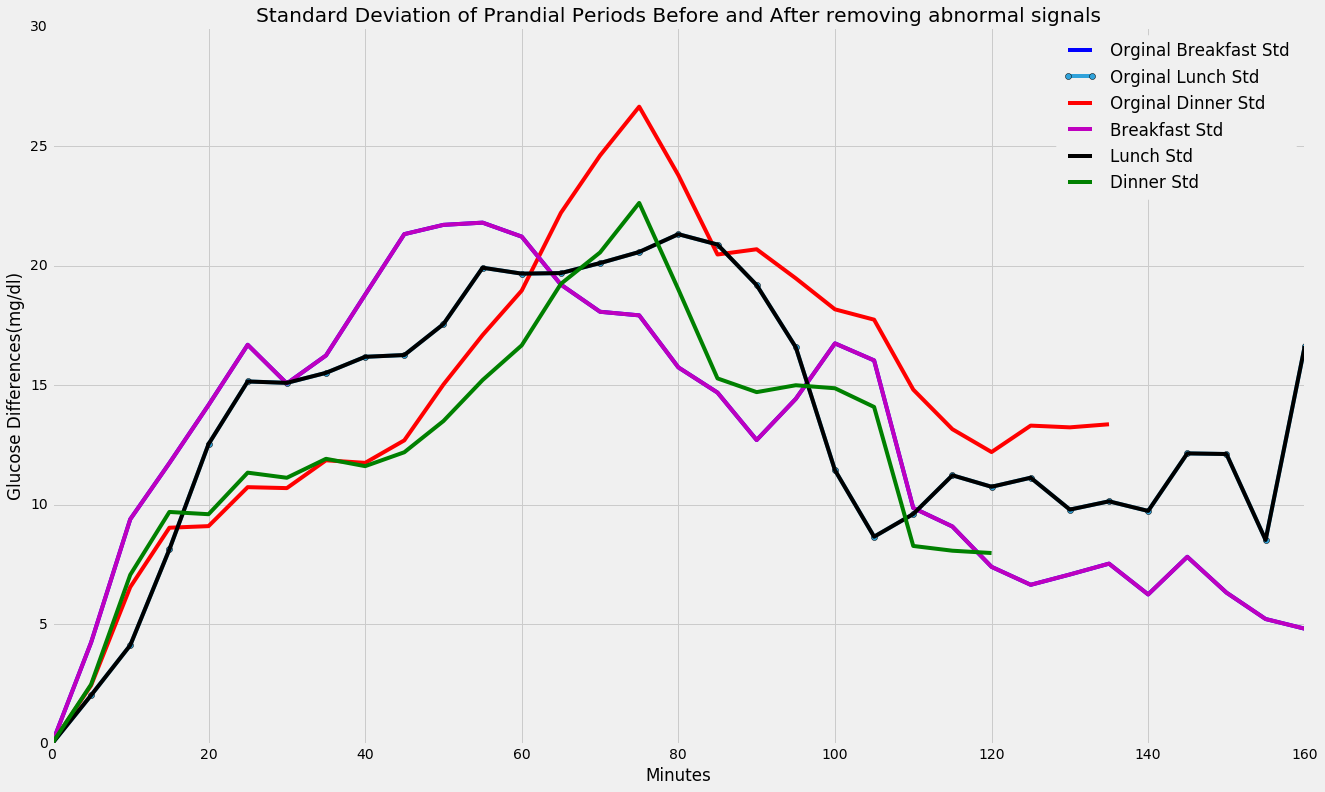

In [499]:
#Calculate the mean at each time increment after meal
 
   
postmeal_breakfast_mean = np.nanmean(breakfast_signals_df_cleaned, axis=0)
postmeal_breakfast_std = np.nanstd(breakfast_signals_df_cleaned, axis=0)
#print "Number of 5mins increments in the lunch df is:", lunch_signals_df.shape[1]
postmeal_lunch_mean = np.nanmean(lunch_signals_df_cleaned, axis=0)
postmeal_lunch_std = np.nanstd(lunch_signals_df_cleaned, axis=0)

#print "Number of 5mins increments in the dinner df is:", dinner_signals_df.shape[1]
postmeal_dinner_mean = np.nanmean(dinner_signals_df_cleaned, axis=0)
postmeal_dinner_std = np.nanstd(dinner_signals_df_cleaned, axis=0)

#Plotting std for all periods
plt.figure(figsize=(20,12))

######################################

x_axis = [x*5 for x in range(dinner_signals_df_cleaned.shape[1])]#all periods have same x axis indeces size

####Compare std after removing extreme outliers
org_breakfast_mean = np.nanmean(breakfast_org_df, axis=0)
org_breakfast_std = np.nanstd(breakfast_org_df, axis=0)

org_lunch_mean = np.nanmean(lunch_org_df, axis=0)
org_lunch_std = np.nanstd(lunch_org_df, axis=0)

org_dinner_mean = np.nanmean(dinner_org_df, axis=0)
org_dinner_std = np.nanstd(dinner_org_df, axis=0)

plt.plot(x_axis, org_breakfast_std, 'b-', label = 'Orginal Breakfast Std')
plt.plot(x_axis, org_lunch_std, 'o-', label = 'Orginal Lunch Std')
plt.plot(x_axis, org_dinner_std, 'r-',  label = 'Orginal Dinner Std')

plt.plot(x_axis, postmeal_breakfast_std, 'm-', label = 'Breakfast Std')
plt.plot(x_axis, postmeal_lunch_std, 'k-', label = 'Lunch Std')
plt.plot(x_axis, postmeal_dinner_std, 'g-',  label = 'Dinner Std')

###########

plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Standard Deviation of Prandial Periods Before and After removing abnormal signals'.format(after_reading)
plt.title(title);

### Minimize any BG increase after the peak

We are expecting that BG does not increase past 90 minutes, so if there is an increase on the mean signal we will reduce it to a minimum by multipying by a small factor.

In [500]:
#after 90 minutes, if BG is decreasing => multiply difference between bg of that time instance and lowest point by 0.1

#when next point has bg less than previous lowest bg point, set the new point as the lowest bg point

def decrease_postpeak_variance(prandial_period, plot_show):
    global prandial_mean_wo_nan 
    #Get mean of prandial period
    prandial_mean = np.mean(prandial_period)
    prandial_mean_instances = [round(item,1) for x, item in enumerate(prandial_mean)]
    #print prandial_mean_instances

    #Set all BG readings occuring after 90 minutes to be decreasing, 90 minutes is equivalent to index 90/5 = 18

    i = 90/5
    ii = 150/5
    current_gl = prandial_mean_instances[i]

    while (i<(len(prandial_mean_instances)-1)):
        if(i<ii):
            if (prandial_mean_instances[i+1]>current_gl):
                prandial_mean_instances[i+1] = round(((prandial_mean_instances[i+1]-current_gl) *0.2) + current_gl, 1)
        else:
            if (prandial_mean_instances[i+1]>current_gl):
                prandial_mean_instances[i+1] = round(((prandial_mean_instances[i+1]-current_gl) *0.1) + current_gl, 1)
            else:
                prandial_mean_instances[i+1] = round(current_gl - ((current_gl - prandial_mean_instances[i+1]) *0.2), 1)               
        current_gl = prandial_mean_instances[i+1]
        i += 1    

    #print prandial_mean_instances

#     if (plot_show == True):
#         x_axis = [x*5 for x in range(len(prandial_mean_instances))]
#         plt.figure(figsize=(20,12))
#         #hold on
#         plt.plot(x_axis, prandial_mean_instances, 'k-')
#         plt.show()
    


    prandial_mean_wo_nan = []
    y = [~np.isnan(prandial_mean_instances[:])]
    for k, x in enumerate(prandial_mean_instances):
        if (y[0][k] == True):
            prandial_mean_wo_nan.append(x)

    #print prandial_mean_wo_nan




In [501]:
import copy
import statsmodels.api as sm

def curvefit(signal_pts, wonan, plot_show): 
    global x_v1, p, y_fit
    plot_indeces_all = map(lambda v : v * 5, range(45)) 
    #print signal_pts
    
    if (wonan==False):
        y = signal_pts[:][~np.isnan(signal_pts[:])]
    else:
        y = signal_pts
        

    #print y

    plot_indeces = map(lambda v : v * 5, range(len(y)))
    x = plot_indeces   

    #################
    y2 =[]
    y2[:] = [m + 50 for m in y]#50 is just some random number to shift plot up, so y(0) is not 0 because that will affect fitting
    p2 = np.poly1d(np.polyfit(x, y2, deg=4))
    y_fit = p2(x)
    ###############
    #The polonomial should start from 5 mins instead of 0 mins, so we do not force that y(0) = 0 
    x_v1 = copy.deepcopy(x)
    y_v1 = copy.deepcopy(y)
    x_v1.pop(0)
    y_v1.pop(0)
    ################
    
    #p = np.poly1d(np.polyfit(x_v1, y_v1, deg=5))

    print "\nThe polynomial fitting of the data is:\n\n",p2  
    
    global fig_v1, ax_v1
    
    plot_indeces_all = map(lambda v : v * 5, range(45)) 
    
    if (plot_show == True):
        fig_v1, ax_v1 = plt.subplots(figsize=(20,15))

        ax_v1.plot(plot_indeces, y, label= 'Period Mean Data Points')  
        ax_v1.plot(plot_indeces, y, 'bo', label= '') 
        #ax_v1.plot(x_v1, p(x_v1), label = 'Fitted Curve')   
        ax_v1.plot(x_v1, (y_fit[1:]-50), label = 'Fitted Curve') #This is the correct fitting, starting from minute 5
        #ax_v1.plot(plot_indeces_all, p(plot_indeces_all), label = 'Extrapolation of Smoothed Curve', linestyle='--')   
        legend = ax_v1.legend(shadow=True) 
        #plt.show()



Prandial mean for breakfast...

Adjusted signal, scaled down any post-peak increase...


The polynomial fitting of the data is:

            4             3           2
-9.053e-07 x + 0.0003573 x - 0.04816 x + 2.266 x + 46.65
[0.0, 4.2, 12.1, 17.7, 24.0, 29.8, 35.7, 35.7, 34.0, 31.0, 26.7, 23.4, 21.0, 19.9, 17.7, 14.9, 14.2, 14.5, 15.9, 12.5, 7.9, 7.5, 8.2, 7.4, 5.0, 3.6, 2.8, 2.0, 0.6, -0.3, -1.0, -1.1, -1.3]


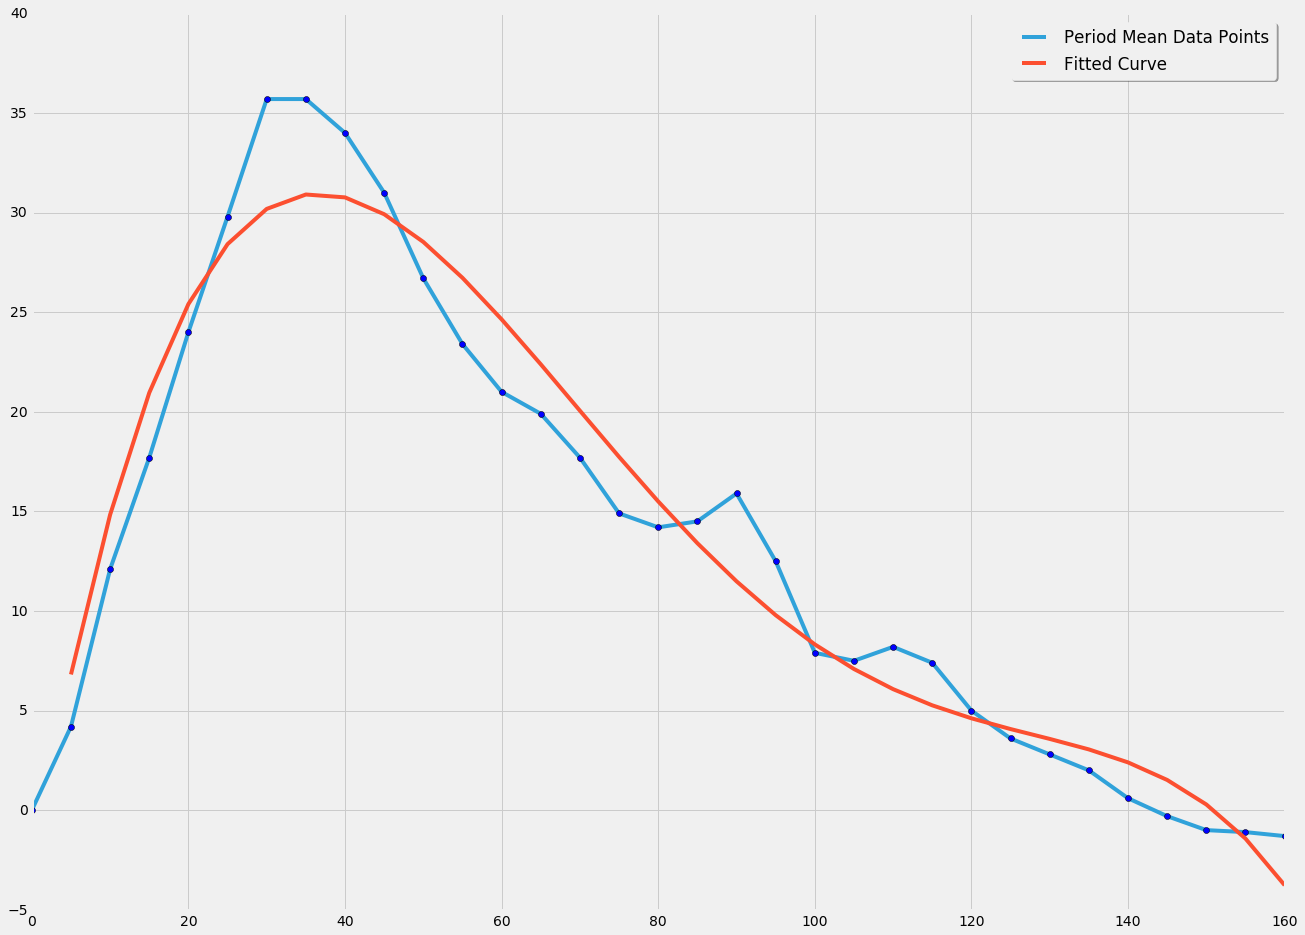

In [502]:
print "Prandial mean for breakfast...\n"
plot_show = True
decrease_postpeak_variance(breakfast_signals_df_cleaned, plot_show)    

# print "Original signal...\n"#without adjustement of minimizing any BG increase
# wonan = False    
# curvefit(postmeal_breakfast_mean,wonan)  


print "Adjusted signal, scaled down any post-peak increase...\n"
wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
breakfast_indeces = copy.deepcopy(x_v1)
breakfast_fit = y_fit[1:]-50

print prandial_mean_wo_nan
breakfast_mean = copy.deepcopy(prandial_mean_wo_nan)

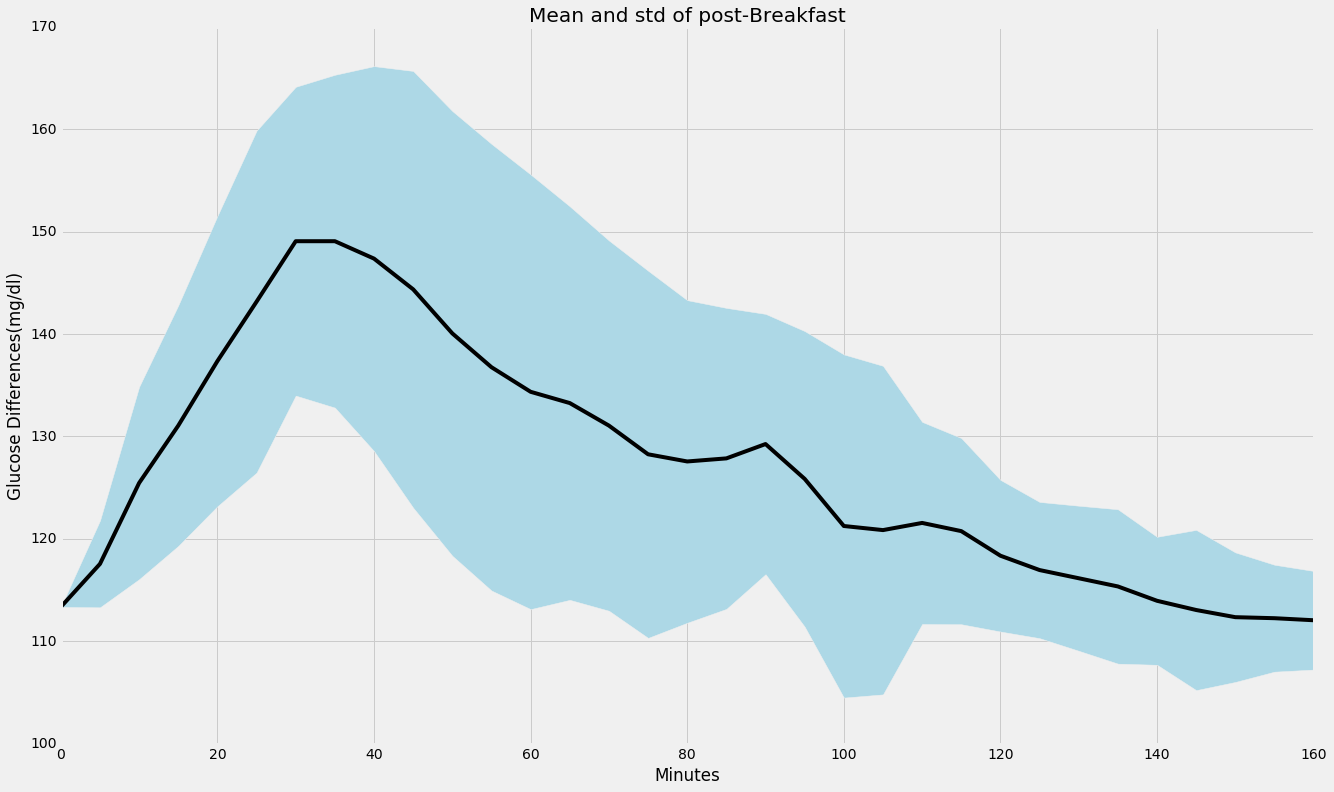

In [503]:
breakfast_pre_bg = round(np.mean(breakfast_preprandial_bg),2)

breakfast_x_axis = [x*5 for x in range(len(breakfast_mean))]
breakfast_std = (postmeal_breakfast_std[:][~np.isnan(postmeal_breakfast_std[:])])
plt.figure(figsize=(20,12))

plt.plot(breakfast_x_axis, np.asarray(breakfast_mean)+breakfast_pre_bg, 'k-')
plt.fill_between(breakfast_x_axis, breakfast_mean-breakfast_std+breakfast_pre_bg, breakfast_mean+breakfast_std+breakfast_pre_bg,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Breakfast'
plt.title(title);

Prandial mean for lunch...

Adjusted signal, scaled down any post-peak increase...


The polynomial fitting of the data is:

            4            3           2
-7.129e-07 x + 0.000282 x - 0.03856 x + 1.935 x + 45.75


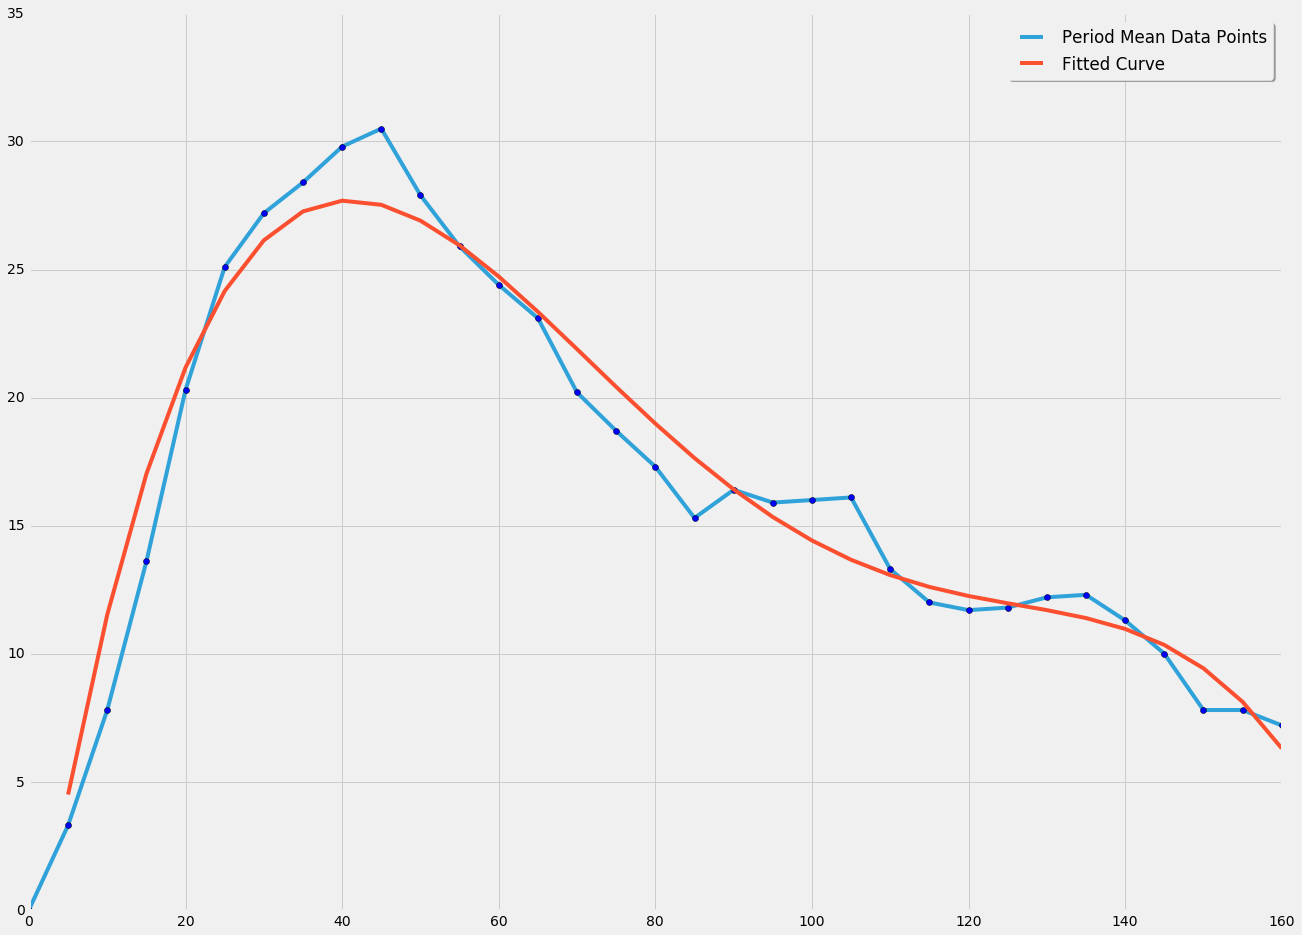

In [504]:
plot_show = True
print "Prandial mean for lunch...\n"
decrease_postpeak_variance(lunch_signals_df_cleaned, plot_show)     

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_lunch_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"
wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)  
lunch_indeces = copy.deepcopy(x_v1)
lunch_mean = copy.deepcopy(prandial_mean_wo_nan)

lunch_fit = y_fit[1:]-50

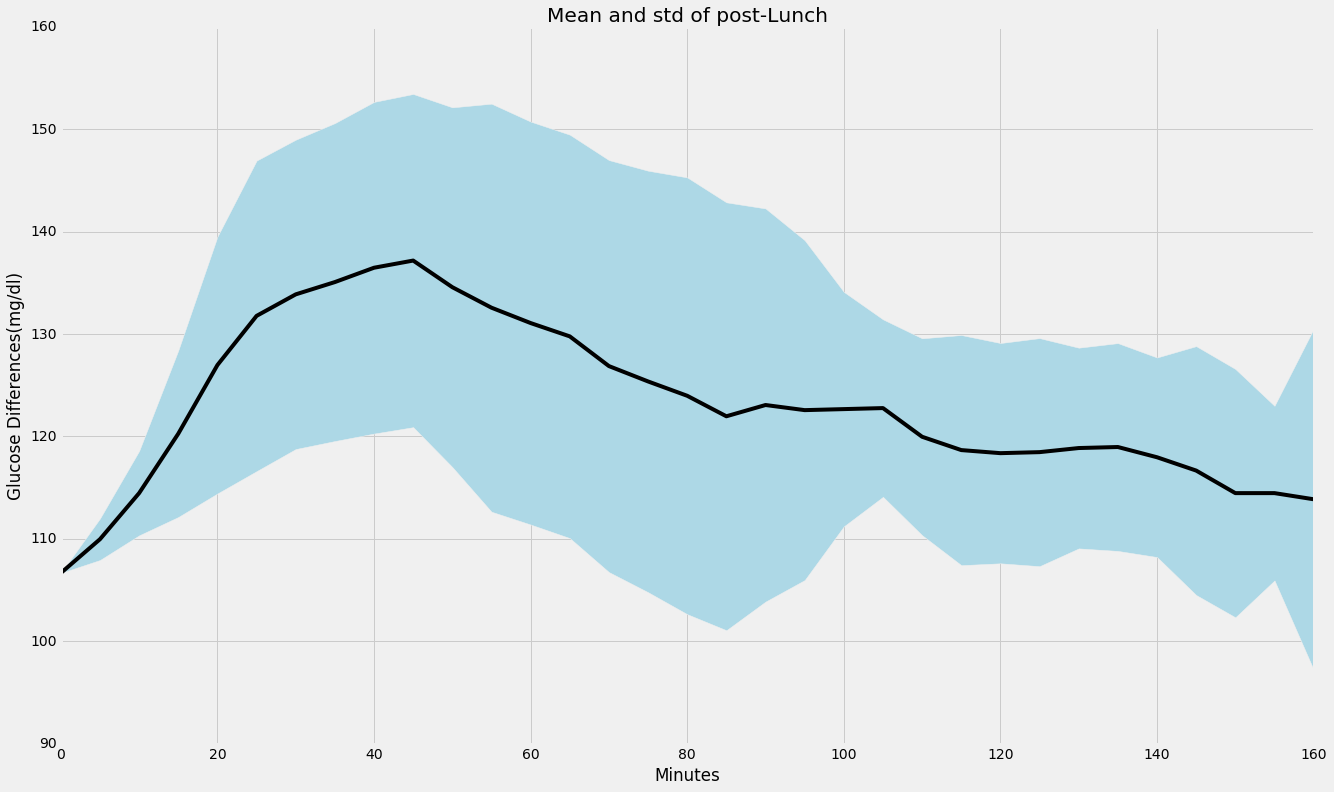

In [505]:
lunch_pre_bg = round(np.mean(lunch_preprandial_bg),2)

lunch_x_axis = [x*5 for x in range(len(lunch_mean))]
lunch_std = (postmeal_lunch_std[:][~np.isnan(postmeal_lunch_std[:])])
plt.figure(figsize=(20,12))

plt.plot(lunch_x_axis, np.asarray(lunch_mean)+lunch_pre_bg, 'k-')
plt.fill_between(lunch_x_axis, lunch_mean-lunch_std+lunch_pre_bg, lunch_mean+lunch_std+lunch_pre_bg,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Lunch'
plt.title(title);

Prandial mean for dinner...

Adjusted signal, scaled down any post-peak increase...


The polynomial fitting of the data is:

           4             3            2
1.021e-06 x - 0.0001451 x - 0.005078 x + 1.002 x + 49.26


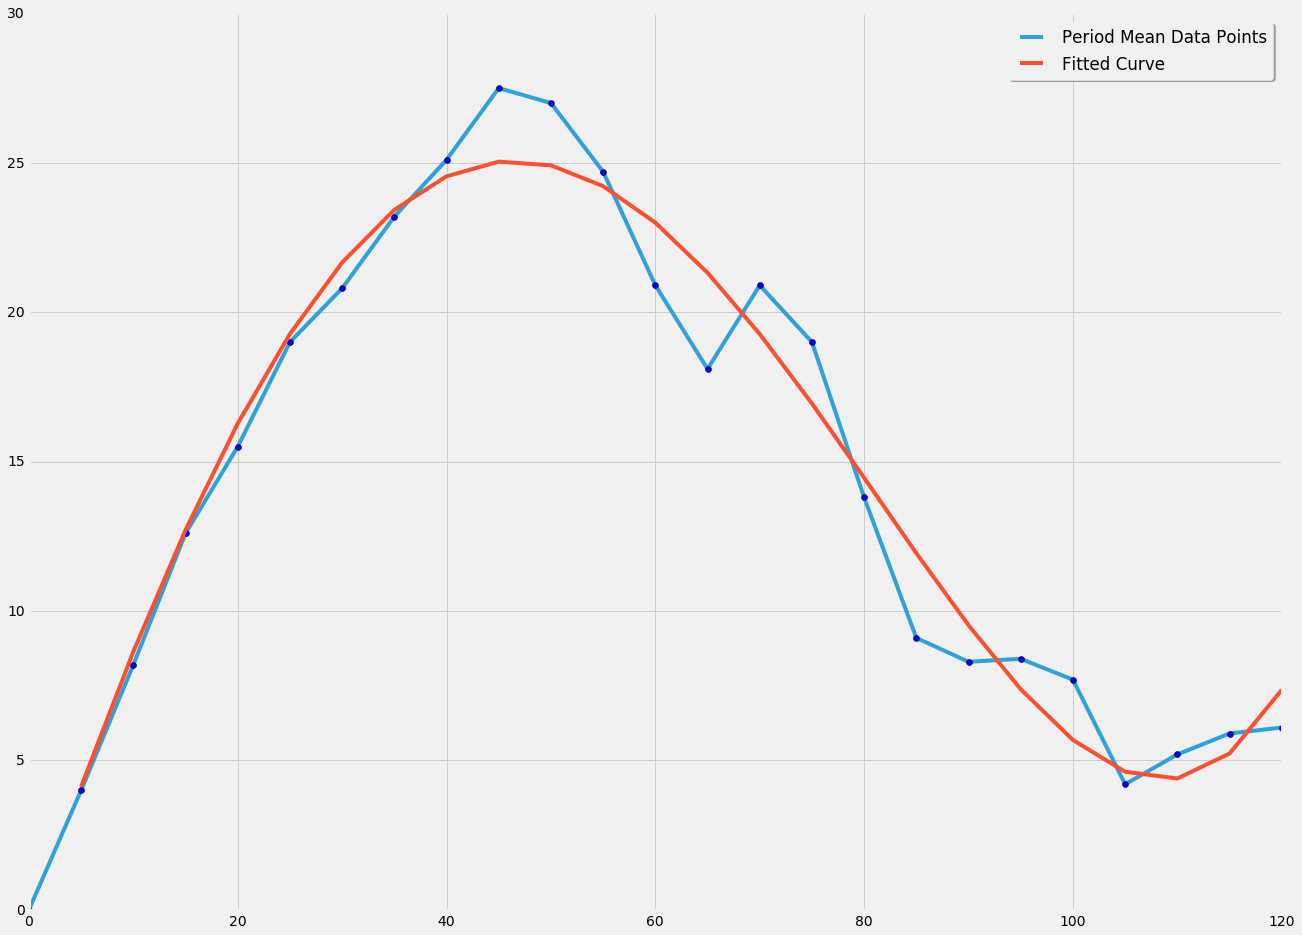

In [506]:
plot_show = True
print "Prandial mean for dinner...\n"
decrease_postpeak_variance(dinner_signals_df_cleaned, plot_show)    

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_dinner_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"

wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
dinner_indeces = copy.deepcopy(x_v1)
dinner_mean = copy.deepcopy(prandial_mean_wo_nan)

dinner_fit = y_fit[1:]-50

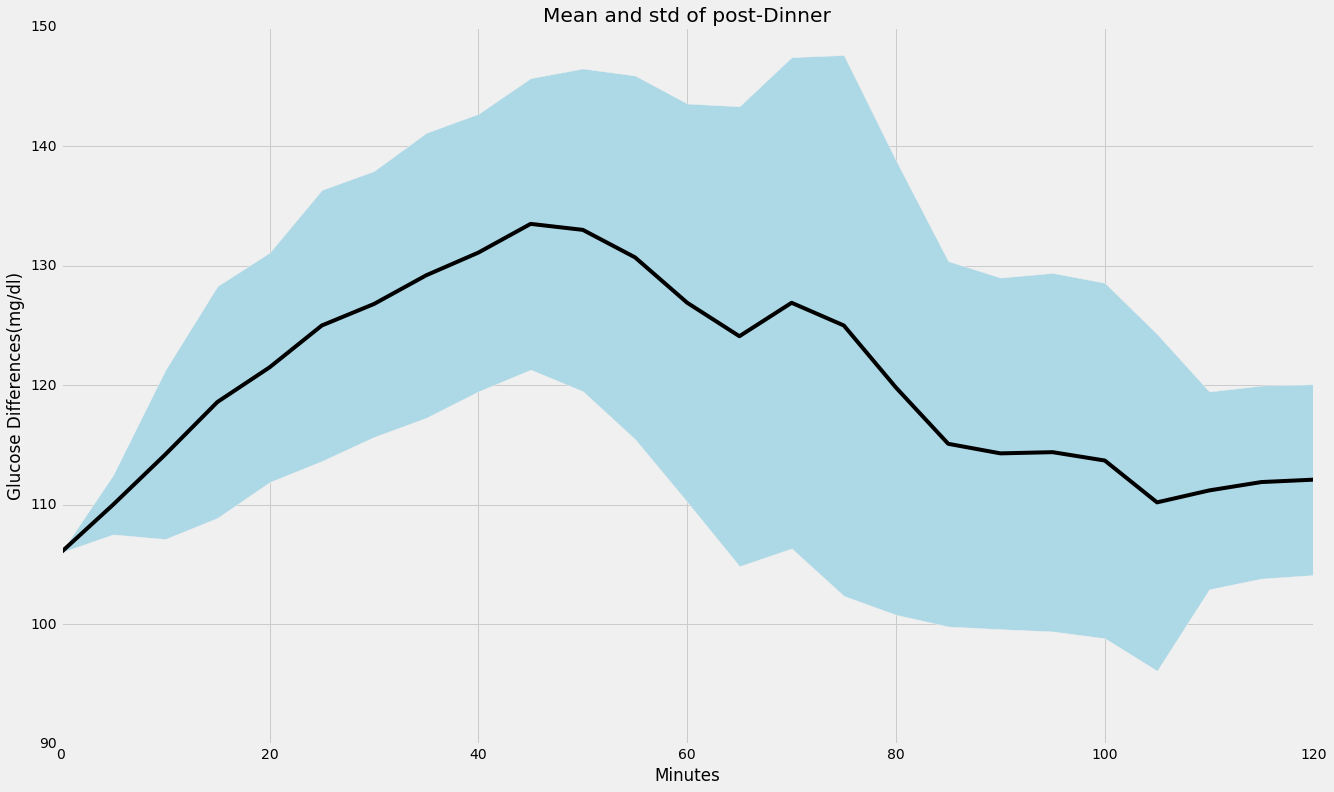

In [507]:
dinner_pre_bg = round(np.mean(dinner_preprandial_bg),2)


dinner_x_axis = [x*5 for x in range(len(dinner_mean))]
dinner_std = (postmeal_dinner_std[:][~np.isnan(postmeal_dinner_std[:])])
plt.figure(figsize=(20,12))

plt.plot(dinner_x_axis, np.asarray(dinner_mean)+dinner_pre_bg, 'k-')
plt.fill_between(dinner_x_axis, dinner_mean-dinner_std+dinner_pre_bg, dinner_mean+dinner_std+dinner_pre_bg,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of post-Dinner'
plt.title(title);

Prandial mean from ALL signals...

Adjusted signal, scaled down any post-peak increase...


The polynomial fitting of the data is:

            4             3           2
-4.676e-07 x + 0.0002126 x - 0.03281 x + 1.76 x + 47.78


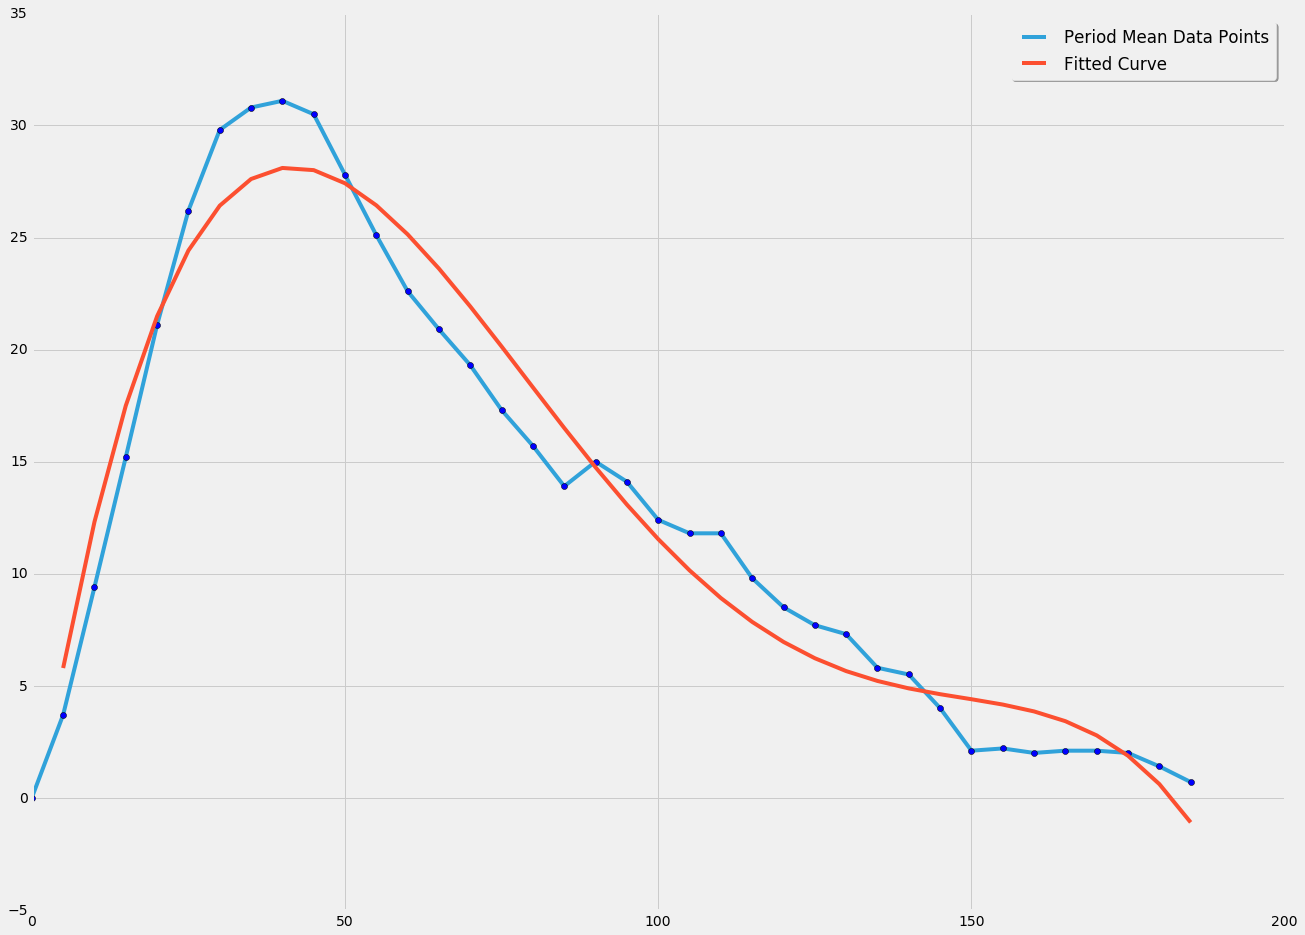

In [508]:
plot_show = True
print "Prandial mean from ALL signals...\n"
decrease_postpeak_variance(all_signals_df_cleaned, plot_show)    

#print all_signals_df_cleaned

# print "Original signal...\n"
# wonan = False    
# curvefit(postmeal_dinner_mean,wonan)  

print "Adjusted signal, scaled down any post-peak increase...\n"

wonan = True  
curvefit(prandial_mean_wo_nan,wonan, plot_show)
all_combined_indeces = copy.deepcopy(x_v1)

all_mean = copy.deepcopy(prandial_mean_wo_nan)
all_fit = y_fit[1:]-50

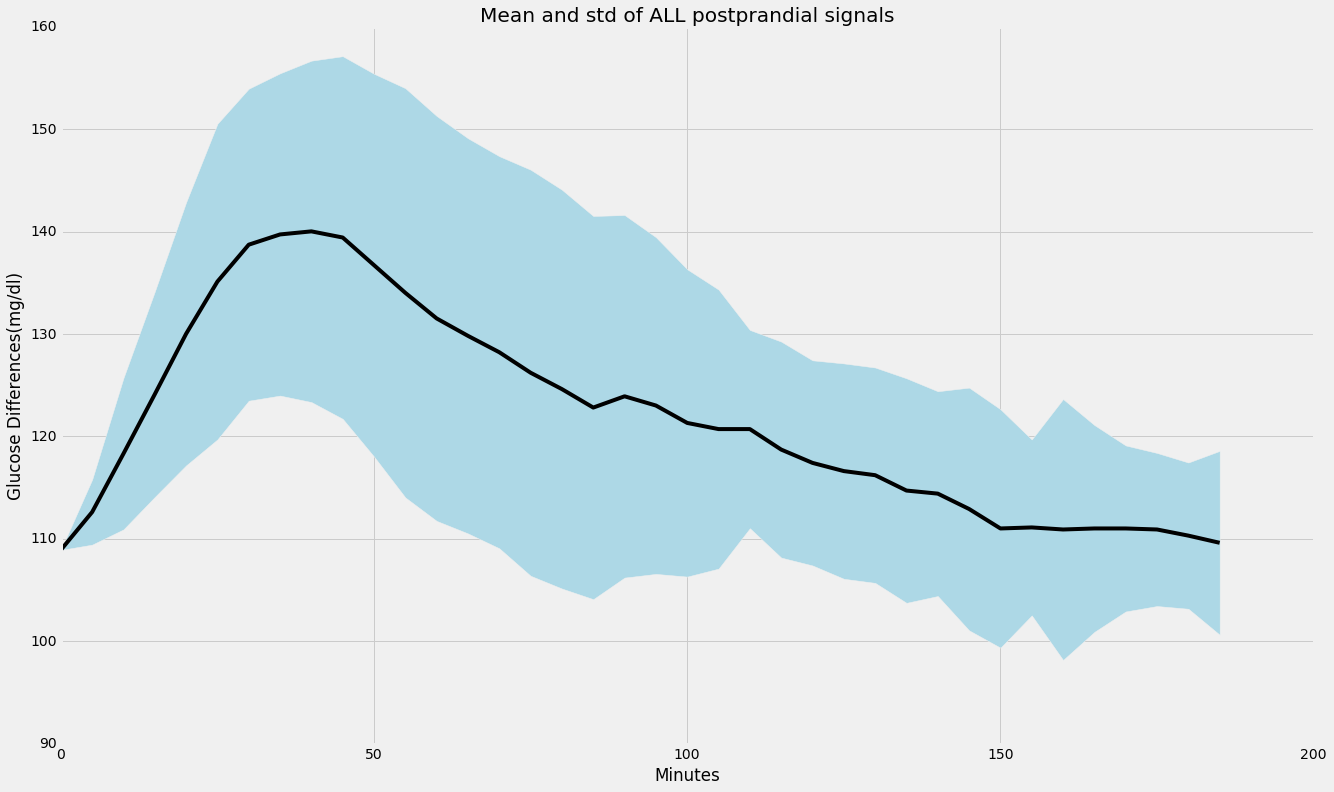

In [509]:
all_pre_bg = round(np.mean(all_preprandial_bg),2)


all_x_axis = [x*5 for x in range(len(all_mean))]
all_std = (postmeal_all_std[:][~np.isnan(postmeal_all_std[:])])
plt.figure(figsize=(20,12))

plt.plot(all_x_axis, np.asarray(all_mean) + all_pre_bg, 'k-')
plt.fill_between(all_x_axis, all_mean-all_std+ all_pre_bg, all_mean+all_std+ all_pre_bg,facecolor='lightblue')
plt.xlabel('Minutes')
plt.ylabel('Glucose Differences(mg/dl)')
plt.legend(loc='upper right')
title = 'Mean and std of ALL postprandial signals'
plt.title(title);

These arrays contain the preprandial BG of the signals: 

breakfast_preprandial_bg, lunch_preprandial_bg, dinner_preprandial_bg, all_preprandial_bg



These dataframes contain the full postprandial signals, aligned at 0 at mealtime:

breakfast_signals_df_cleaned, lunch_signals_df_cleaned, dinner_signals_df_cleaned, all_signals_df_cleaned


In [510]:
breakfast_signal_wpre = copy.deepcopy(breakfast_signals_df_cleaned)
lunch_signal_wpre = copy.deepcopy(lunch_signals_df_cleaned)
dinner_signal_wpre = copy.deepcopy(dinner_signals_df_cleaned)
all_signal_wpre = copy.deepcopy(all_signals_df_cleaned)

def add_preprandial_bg(period, preprandialBG):
    for k in range(period.shape[0]):
        period.iloc[k,:] = period.iloc[k,:] + preprandialBG[k]
    
add_preprandial_bg(breakfast_signal_wpre, breakfast_preprandial_bg)    
add_preprandial_bg(lunch_signal_wpre, lunch_preprandial_bg)  
add_preprandial_bg(dinner_signal_wpre, dinner_preprandial_bg)  
add_preprandial_bg(all_signal_wpre, all_preprandial_bg)  


In [562]:
#Save full postprandial period signals into a csv file, select the period
####these are offset with mean preprandial BG level of that specific period

# breakfast_signal_wpre.to_csv("P5_breakfast_postprandial.csv", sep=',',  index=False, header=False)
# lunch_signal_wpre.to_csv("P5_lunch_postprandial.csv", sep=',',  index=False, header=False)
# dinner_signal_wpre.to_csv("P5_dinner_postprandial.csv", sep=',',  index=False, header=False)
# all_signal_wpre.to_csv("P5_all_postprandial.csv", sep=',',  index=False, header=False)

####these are not offset with mean preprandial BG level of that specific period
breakfast_signals_df_cleaned.to_csv("P5_breakfast_postprandial.csv", sep=',',  index=False)
lunch_signals_df_cleaned.to_csv("P5_lunch_postprandial.csv", sep=',',  index=False)
dinner_signals_df_cleaned.to_csv("P5_dinner_postprandial.csv", sep=',',  index=False)
all_signals_df_cleaned.to_csv("P5_all_postprandial.csv", sep=',',  index=False)
    

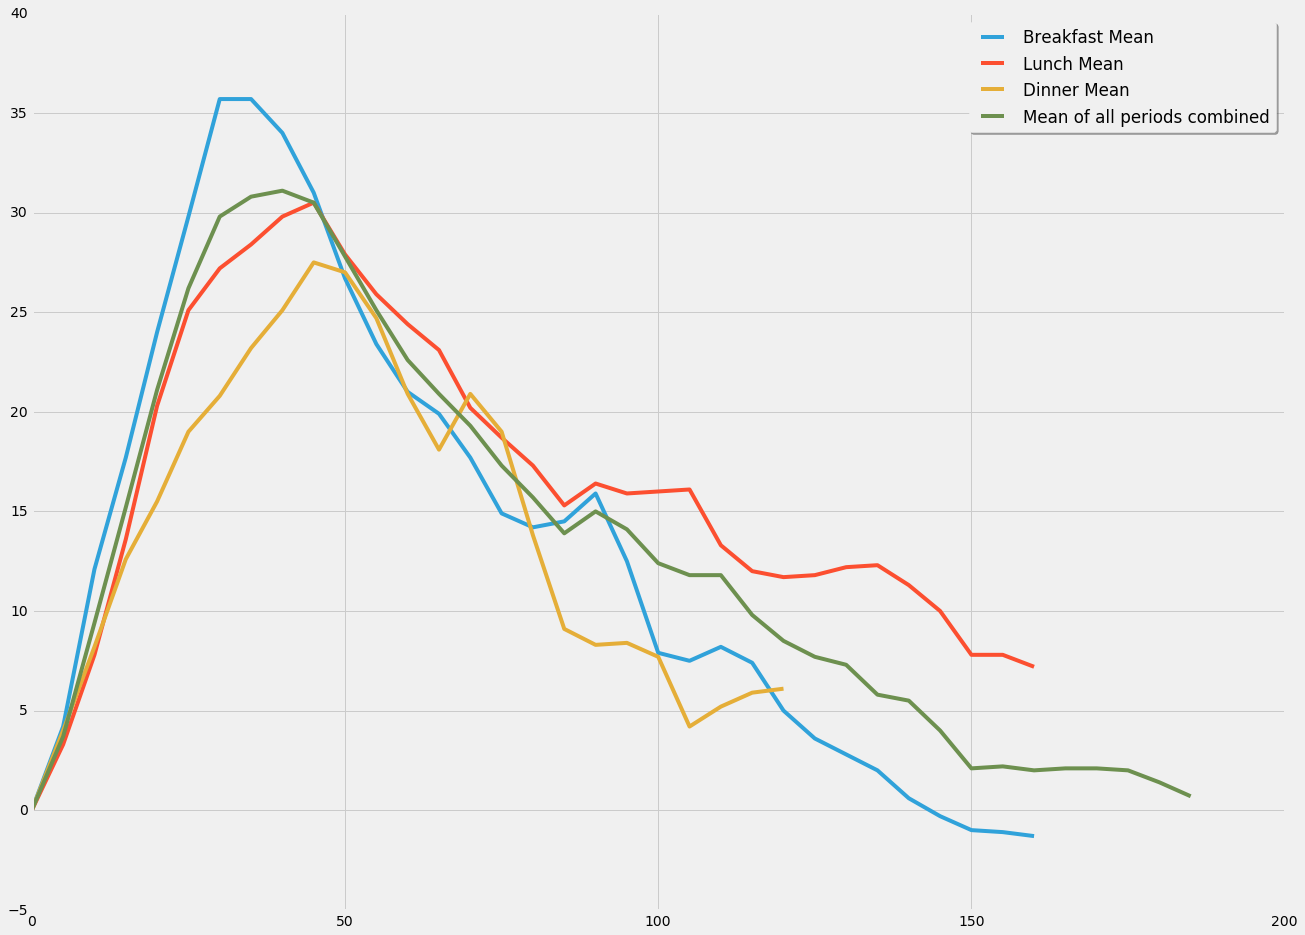

In [512]:
fig_v1, ax_v1 = plt.subplots(figsize=(20,15))

ax_v1.plot(breakfast_x_axis, breakfast_mean, label = 'Breakfast Mean')
ax_v1.plot(lunch_x_axis, lunch_mean, label = 'Lunch Mean')
ax_v1.plot(dinner_x_axis, dinner_mean, label = 'Dinner Mean')
ax_v1.plot(all_x_axis, all_mean, label = 'Mean of all periods combined')

# Aligned at the mean of the period instead at 0

# ax_v1.plot(breakfast_x_axis, np.asarray(breakfast_mean) + breakfast_pre_bg , label = 'Breakfast Mean')
# ax_v1.plot(lunch_x_axis, np.asarray(lunch_mean)+ lunch_pre_bg, label = 'Lunch Mean')
# ax_v1.plot(dinner_x_axis, np.asarray(dinner_mean)+ dinner_pre_bg, label = 'Dinner Mean')
# ax_v1.plot(all_x_axis, np.asarray(all_mean) + all_pre_bg, label = 'Mean of all periods combined')

legend = ax_v1.legend(shadow=True) 
plt.show()

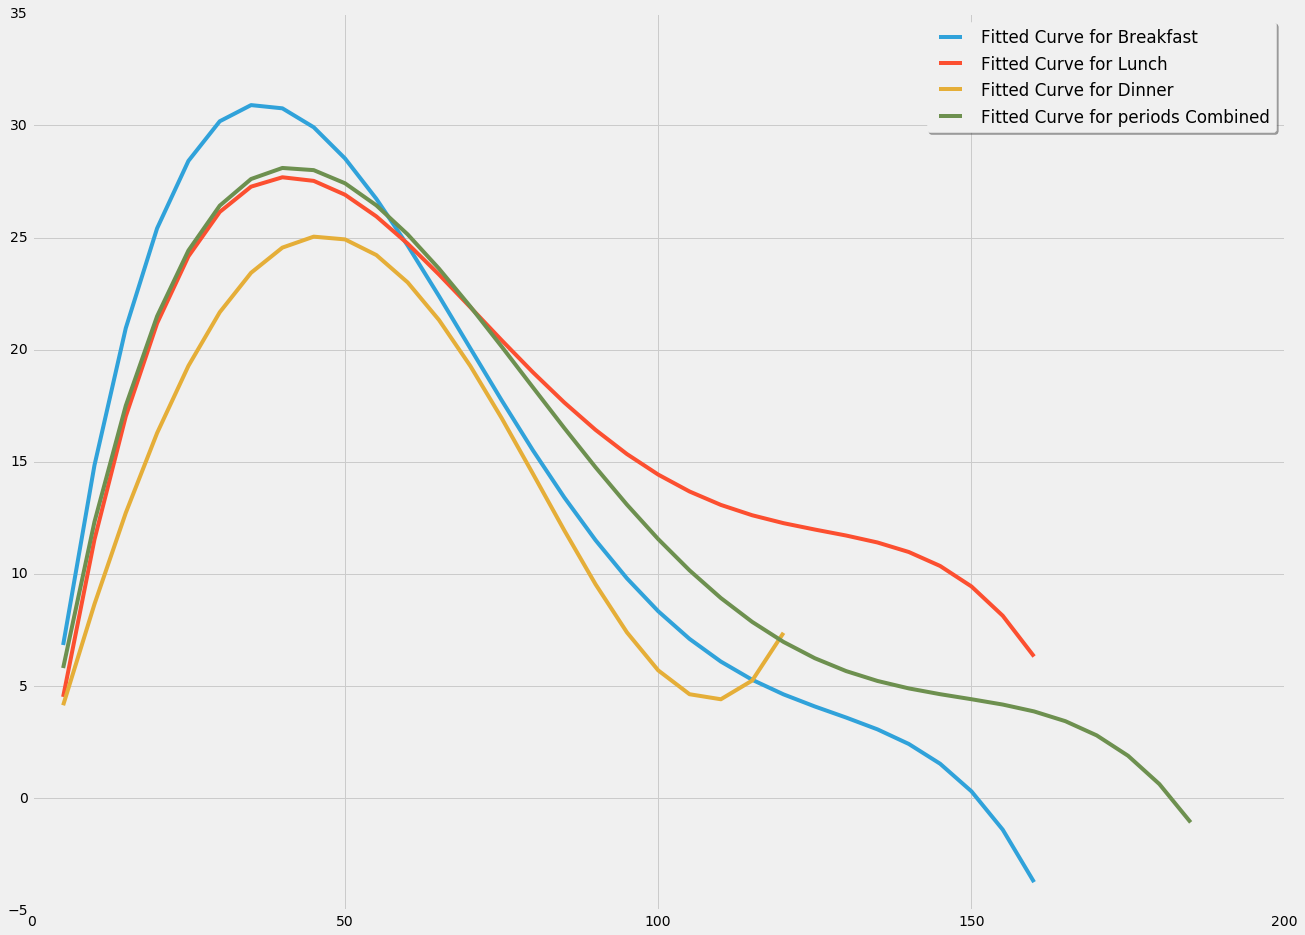

In [513]:
fig_v1, ax_v1 = plt.subplots(figsize=(20,15))

ax_v1.plot(breakfast_indeces, breakfast_fit, label = 'Fitted Curve for Breakfast')
ax_v1.plot(lunch_indeces, lunch_fit, label = 'Fitted Curve for Lunch')
ax_v1.plot(dinner_indeces, dinner_fit, label = 'Fitted Curve for Dinner')
ax_v1.plot(all_combined_indeces, all_fit, label = 'Fitted Curve for periods Combined')

legend = ax_v1.legend(shadow=True) 
plt.show()

**Saving polynomial output data points into a csv file** 

Uncomment below if we are saving

In [514]:
# a = [breakfast_fit,lunch_fit ,dinner_fit,all_fit]
# print a
    
# # np.savetxt("P1_Polyfitdeg5_Lunch.csv", a ,  delimiter=',', header="Breakfast Mean, Lunch Mean, Dinner Mean, All combined Mean", fmt='%2f')
# import csv
# with open("P1_Polyfitdeg4.csv", "wb") as f:
#     writer = csv.writer(f)
#     writer.writerows(a)


## Online Learning

Steps:

1. Pick some generic postprandial BG plot
2. Pick some other significantly different postprandial BG signal
3. Select few points from the second plot and add to first plot, by average or weighing previous and new points differently
4. Curve fit new data points and show previous and new polynomial
5. Repeat steps 3 and 4, show error (MAE) at each iteration
6. Reduce number of points provided, repeat steps 3, 4, 5

Step 1: Selecting above postprandial Breakfast Mean signals as our Generic Plot (this is done to test online learning only, any other generic plot can be used)

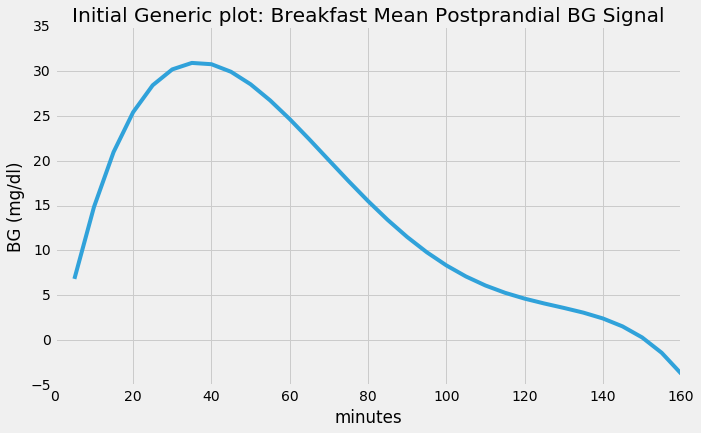

In [515]:
#print p_breakfast(breakfast_indeces) #Output of polynomial, it starts at 5mins, check breakfast_indeces

#Add instance 0 for plotting full poly fitted signal

plt.figure(figsize=(10,6))
plt.plot(breakfast_indeces, breakfast_fit)
plt.xlabel('minutes')
plt.ylabel('BG (mg/dl)')
plt.title('Initial Generic plot: Breakfast Mean Postprandial BG Signal')
plt.show()

Step 2: Selecting a postprandial from dinner, which looks significantly different than our generic initial plot.

Input test signal (Desired output) from dinner period, which has a length of 14 signals:
5


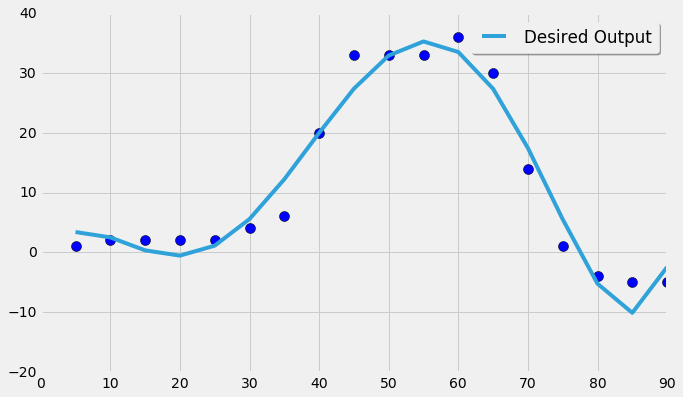


Initial BG postprandial plot overlayed with the desired output signal



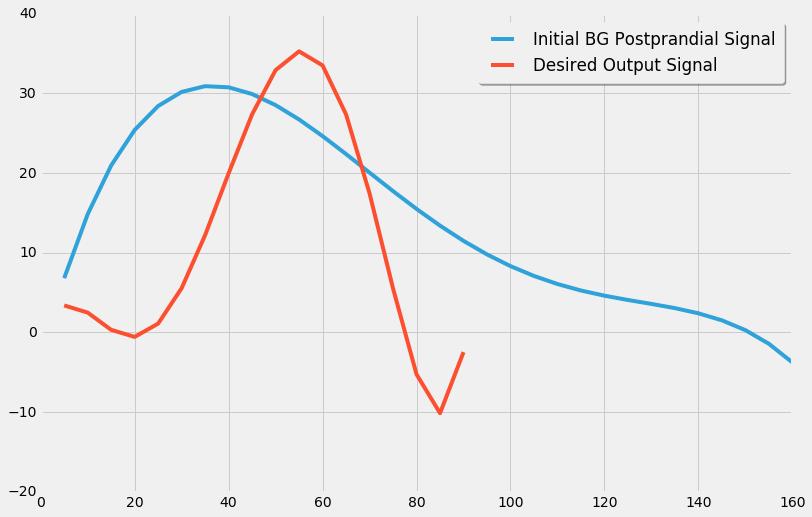

In [516]:
print "Input test signal (Desired output) from dinner period, which has a length of", dinner_df.shape[0] , "signals:"

j = input("")

desired_signal = dinner_df.iloc[j]

desired_y = desired_signal[:][~np.isnan(desired_signal[:])]

desired_y =  desired_y - desired_y[0]

x_indeces = map(lambda v : v * 5, range(len(desired_y)))

x_indeces_wo_0ind = copy.deepcopy(x_indeces)
x_indeces_wo_0ind.pop(0)


y2 =[]
y2[:] = [m + 50 for m in desired_y]#50 is just some random number to shift plot up, so y(0) is not 0 because that will affect fitting
p2 = np.poly1d(np.polyfit(x_indeces, y2, deg=5))
y_fit = p2(x_indeces)

test_fit = y_fit[1:]-50

desired_y.pop(0)
plt.figure(figsize=(10,6))
plt.plot(x_indeces_wo_0ind, desired_y, 'bo', markersize='10', label= '')  
plt.plot(x_indeces_wo_0ind, test_fit , label = 'Desired Output')   
plt.legend(shadow=True)
plt.show()


# test_fit =  [0] + test_fit.tolist()
# x_indeces_wo_0ind = [0] + x_indeces_wo_0ind

######################Overlay initial signal with desired output to visualize
print "\nInitial BG postprandial plot overlayed with the desired output signal\n"
plt.figure(figsize=(12,8))
plt.plot(breakfast_indeces, breakfast_fit , label='Initial BG Postprandial Signal')
plt.plot(x_indeces_wo_0ind, test_fit, label = 'Desired Output Signal') 
plt.legend(shadow=True, borderpad=0.5)
plt.show()

Plot all patients Mean postprandial signals combined and compare

In [517]:
import csv

with open('P1_Polyfitdeg5.csv', 'rb') as f:
    reader = csv.reader(f)
    print "\nPatient 1\n"
    for i, row in enumerate(reader):
        if (i == 0):
            P1_Breakfast_Mean = row
        if (i == 1):
            P1_Lunch_Mean = row        
        if (i == 2):
            P1_Dinner_Mean = row        
        if (i == 3):
            P1_ALL_Mean = row
            
# P1_Breakfast_Mean = map(float, P1_Breakfast_Mean)  
# if(P1_Breakfast_Mean[0] <0): 
#     P1_Breakfast_Mean[:] = [x + abs(P1_Breakfast_Mean[0]) for x in P1_Breakfast_Mean]
# else:
#     P1_Breakfast_Mean[:] = [x - P1_Breakfast_Mean[0] for x in P1_Breakfast_Mean] 

# P1_Lunch_Mean = map(float, P1_Lunch_Mean)  
# if(P1_Lunch_Mean[0] <0): 
#     P1_Lunch_Mean[:] = [x + abs(P1_Lunch_Mean[0]) for x in P1_Lunch_Mean]
# else:
#     P1_Lunch_Mean[:] = [x - P1_Lunch_Mean[0] for x in P1_Lunch_Mean]    
    
# P1_Dinner_Mean = map(float, P1_Dinner_Mean)  
# if(P1_Dinner_Mean[0] <0): 
#     P1_Dinner_Mean[:] = [x + abs(P1_Dinner_Mean[0]) for x in P1_Dinner_Mean]
# else:
#     P1_Dinner_Mean[:] = [x - P1_Dinner_Mean[0] for x in P1_Dinner_Mean]    
             
# P1_ALL_Mean = map(float, P1_ALL_Mean)  
# if(P1_ALL_Mean[0] <0): 
#     P1_ALL_Mean[:] = [x + abs(P1_ALL_Mean[0]) for x in P1_ALL_Mean]
# else:
#     P1_ALL_Mean[:] = [x - P1_ALL_Mean[0] for x in P1_ALL_Mean] 
    
print P1_ALL_Mean   


Patient 1

['5.7914928549054991', '16.801577295068', '25.746660162233013', '32.832483597168505', '38.253346062880127', '42.192367336068656', '44.821753498587327', '46.303061928899382', '46.787466293535346', '46.416021538550609', '45.319928880982701', '43.620800800308714', '41.430926029902878', '38.853534548493826', '35.983062571622028', '32.905417543097258', '29.698243126456106', '26.431184196419125', '23.166151830348525', '19.957588299705478', '16.852732061507481', '13.891882749785871', '11.108666167043324', '8.5302992757108242', '6.1778551896059639', '4.0665281653892507', '2.2058985940223579', '0.60019799222543213', '-0.75142600606594812', '-1.8546446582428828', '-2.7196831215657724', '-3.3610554617072452', '-3.7972996612946659', '-4.0507126284516772', '-4.1470852053431102', '-4.1154371767144582', '-3.9877522784378741', '-3.7987132060513318', '-3.5854366233042185', '-3.3872081706972921', '-3.2452174740280952', '-3.2022931529306291', '-3.3026378294193179', '-3.5915631364326757', '-4.

In [518]:
with open('P2_Polyfitdeg5.csv', 'rb') as f:
    reader = csv.reader(f)
    print "\nPatient 2\n"
    for i, row in enumerate(reader):
        if (i == 0):
            P2_Breakfast_Mean = row
        if (i == 1):
            P2_Lunch_Mean = row        
        if (i == 2):
            P2_Dinner_Mean = row        
        if (i == 3):
            P2_ALL_Mean = row
            
# P2_Breakfast_Mean = map(float, P2_Breakfast_Mean)  
# if(P2_Breakfast_Mean[0] <0): 
#     P2_Breakfast_Mean[:] = [x + abs(P2_Breakfast_Mean[0]) for x in P2_Breakfast_Mean]
# else:
#     P2_Breakfast_Mean[:] = [x - P2_Breakfast_Mean[0] for x in P2_Breakfast_Mean] 

# P2_Lunch_Mean = map(float, P2_Lunch_Mean)  
# if(P2_Lunch_Mean[0] <0): 
#     P2_Lunch_Mean[:] = [x + abs(P2_Lunch_Mean[0]) for x in P2_Lunch_Mean]
# else:
#     P2_Lunch_Mean[:] = [x - P2_Lunch_Mean[0] for x in P2_Lunch_Mean]    
    
# P2_Dinner_Mean = map(float, P2_Dinner_Mean)  
# if(P2_Dinner_Mean[0] <0): 
#     P2_Dinner_Mean[:] = [x + abs(P2_Dinner_Mean[0]) for x in P2_Dinner_Mean]
# else:
#     P2_Dinner_Mean[:] = [x - P2_Dinner_Mean[0] for x in P2_Dinner_Mean]  
    
# P2_ALL_Mean = map(float, P2_ALL_Mean)            
# if(P2_ALL_Mean[0] <0): 
#     P2_ALL_Mean[:] = [x + abs(P2_ALL_Mean[0]) for x in P2_ALL_Mean]
# else:
#     P2_ALL_Mean[:] = [x - P2_ALL_Mean[0] for x in P2_ALL_Mean] 
    
print P2_ALL_Mean   


Patient 2

['3.6136693256258212', '9.2907809188210422', '13.965986791671995', '17.732686949132969', '20.679114464549514', '22.888471527439279', '24.439065491272657', '25.40444492125367', '25.853535642100638', '25.850776785827051', '25.456256839522212', '24.725849693132133', '23.71135068724017', '22.460612660847914', '21.017681999155855', '19.422934681344245', '17.713212328353777', '15.921958250666393', '14.079353496086043', '12.212452897519483', '10.345321120756992', '8.4991687122531516', '6.6924881469076567', '4.9411898758459998', '3.2587383742003055', '1.6562881888901231', '0.14281998640311144', '-1.2747233994242464', '-2.5913009196255814', '-3.8036372623243722', '-4.9100868049525204', '-5.9104975664703687', '-6.8060751595850135', '-7.5992467429705286', '-8.2935249734864414', '-8.8933719583970472', '-9.4040632075915767', '-9.8315515858017832', '-10.182331264822679', '-10.463301675730719', '-10.681631461103692', '-10.84462242723999', '-10.959573496377288', '-11.03364465891201', '-11.

In [519]:
with open('P4_Polyfitdeg5.csv', 'rb') as f:
    reader = csv.reader(f)
    print "\nPatient 4\n"
    for i, row in enumerate(reader):
        if (i == 0):
            P4_Breakfast_Mean = row
        if (i == 1):
            P4_Lunch_Mean = row        
        if (i == 2):
            P4_Dinner_Mean = row        
        if (i == 3):
            P4_ALL_Mean = row
            
# P4_Breakfast_Mean = map(float, P4_Breakfast_Mean)  
# if(P4_Breakfast_Mean[0] <0): 
#     P4_Breakfast_Mean[:] = [x + abs(P4_Breakfast_Mean[0]) for x in P4_Breakfast_Mean]
# else:
#     P4_Breakfast_Mean[:] = [x - P4_Breakfast_Mean[0] for x in P4_Breakfast_Mean] 

# P4_Lunch_Mean = map(float, P4_Lunch_Mean)  
# if(P4_Lunch_Mean[0] <0): 
#     P4_Lunch_Mean[:] = [x + abs(P4_Lunch_Mean[0]) for x in P4_Lunch_Mean]
# else:
#     P4_Lunch_Mean[:] = [x - P4_Lunch_Mean[0] for x in P4_Lunch_Mean]    
    
# P4_Dinner_Mean = map(float, P4_Dinner_Mean)  
# if(P4_Dinner_Mean[0] <0): 
#     P4_Dinner_Mean[:] = [x + abs(P4_Dinner_Mean[0]) for x in P4_Dinner_Mean]
# else:
#     P4_Dinner_Mean[:] = [x - P4_Dinner_Mean[0] for x in P4_Dinner_Mean] 
    
# P4_ALL_Mean = map(float, P4_ALL_Mean)
# if(P4_ALL_Mean[0] <0): 
#     P4_ALL_Mean[:] = [x + abs(P4_ALL_Mean[0]) for x in P4_ALL_Mean]
# else:
#     P4_ALL_Mean[:] = [x - P4_ALL_Mean[0] for x in P4_ALL_Mean] 
    
print P4_ALL_Mean               


Patient 4

['3.5649632078772413', '9.2689724076218099', '13.820461170130159', '17.343796537607474', '19.955459047831056', '21.764276219434606', '22.871656037192338', '23.371820437303228', '23.352038792675174', '22.892861398209192', '22.068352956083629', '20.946326061038363', '19.588574685658912', '18.051107665660737', '16.38438218517345', '14.633537262024802', '12.838627233025107', '11.034855239251343', '9.2528067113313526', '7.5186828547279987', '5.8545341350234565', '4.2784937632032012', '2.8050111809405252', '1.4450855458803389', '0.20649921692382378', '-0.90594876048784556', '-1.8902091690890472', '-2.7467491345054853', '-3.4783186399700838', '-4.08971704103908', '-4.5875595803069729', '-4.9800439021233984', '-5.2767165673081777', '-5.4882395678674314', '-5.6261568417094026', '-5.7026607873599957', '-5.7303587786793031', '-5.722039679576028', '-5.6904403587251124', '-5.6480122042818977', '-5.6066876385989985', '-5.5776466329415442', '-5.5710832222030717', '-5.5959720196219251', '-

In [520]:
with open('P5_Polyfitdeg5.csv', 'rb') as f:
    reader = csv.reader(f)
    print "\nPatient 5\n"
    for i, row in enumerate(reader):
        if (i == 0):
            P5_Breakfast_Mean = row
        if (i == 1):
            P5_Lunch_Mean = row        
        if (i == 2):
            P5_Dinner_Mean = row        
        if (i == 3):
            P5_ALL_Mean = row
            
# P5_Breakfast_Mean = map(float, P5_Breakfast_Mean)  
# if(P5_Breakfast_Mean[0] <0): 
#     P5_Breakfast_Mean[:] = [x + abs(P5_Breakfast_Mean[0]) for x in P5_Breakfast_Mean]
# else:
#     P5_Breakfast_Mean[:] = [x - P5_Breakfast_Mean[0] for x in P5_Breakfast_Mean] 

# P5_Lunch_Mean = map(float, P5_Lunch_Mean)  
# if(P5_Lunch_Mean[0] <0): 
#     P5_Lunch_Mean[:] = [x + abs(P5_Lunch_Mean[0]) for x in P5_Lunch_Mean]
# else:
#     P5_Lunch_Mean[:] = [x - P5_Lunch_Mean[0] for x in P5_Lunch_Mean]    
    
# P5_Dinner_Mean = map(float, P5_Dinner_Mean)  
# if(P5_Dinner_Mean[0] <0): 
#     P5_Dinner_Mean[:] = [x + abs(P5_Dinner_Mean[0]) for x in P5_Dinner_Mean]
# else:
#     P5_Dinner_Mean[:] = [x - P5_Dinner_Mean[0] for x in P5_Dinner_Mean] 
    
# P5_ALL_Mean = map(float, P5_ALL_Mean)
# if(P5_ALL_Mean[0] <0): 
#     P5_ALL_Mean[:] = [x + abs(P5_ALL_Mean[0]) for x in P5_ALL_Mean]
# else:
#     P5_ALL_Mean[:] = [x - P5_ALL_Mean[0] for x in P5_ALL_Mean] 
    
print P5_ALL_Mean   


Patient 5

['5.3933940899041986', '13.078183383619496', '18.93450780368984', '23.226800545191708', '26.19512815872497', '28.056299820540787', '29.004976602669615', '29.214780743048962', '28.839404915651485', '28.013721500612775', '26.854891854359323', '25.463475579736482', '23.924539796136258', '22.308768409625401', '20.673571383073153', '19.064194006279294', '17.51482616610204', '16.04971161658581', '14.684257249089384', '13.426142362413628', '12.276427932929622', '11.230665884706177', '10.28000835963838', '9.4123169875745845', '8.6132721564457313', '7.8674822823915775', '7.1595930798899303', '6.4753968318840762', '5.802941659910573', '5.1336407942272331', '4.4633818439417468', '3.7936360671379816', '3.1325676410055507', '2.4961429319672561', '1.9092397658062765', '1.4067566977946768', '1.0347222828217539']


In [521]:
with open('P6_Polyfitdeg5.csv', 'rb') as f:
    reader = csv.reader(f)
    print "\nPatient 6\n"
    for i, row in enumerate(reader):
        if (i == 0):
            P6_Breakfast_Mean = row
        if (i == 1):
            P6_Lunch_Mean = row        
        if (i == 2):
            P6_Dinner_Mean = row        
        if (i == 3):
            P6_ALL_Mean = row
# P6_Breakfast_Mean = map(float, P6_Breakfast_Mean)  
# if(P6_Breakfast_Mean[0] <0): 
#     P6_Breakfast_Mean[:] = [x + abs(P6_Breakfast_Mean[0]) for x in P6_Breakfast_Mean]
# else:
#     P6_Breakfast_Mean[:] = [x - P6_Breakfast_Mean[0] for x in P6_Breakfast_Mean] 

# P6_Lunch_Mean = map(float, P6_Lunch_Mean)  
# if(P6_Lunch_Mean[0] <0): 
#     P6_Lunch_Mean[:] = [x + abs(P6_Lunch_Mean[0]) for x in P6_Lunch_Mean]
# else:
#     P6_Lunch_Mean[:] = [x - P6_Lunch_Mean[0] for x in P6_Lunch_Mean]    
    
# P6_Dinner_Mean = map(float, P6_Dinner_Mean)  
# if(P6_Dinner_Mean[0] <0): 
#     P6_Dinner_Mean[:] = [x + abs(P6_Dinner_Mean[0]) for x in P6_Dinner_Mean]
# else:
#     P6_Dinner_Mean[:] = [x - P6_Dinner_Mean[0] for x in P6_Dinner_Mean] 

# P6_ALL_Mean = map(float, P6_ALL_Mean)                       
# if(P6_ALL_Mean[0] <0): 
#     P6_ALL_Mean[:] = [x + abs(P6_ALL_Mean[0]) for x in P6_ALL_Mean]
# else:
#     P6_ALL_Mean[:] = [x - P6_ALL_Mean[0] for x in P6_ALL_Mean] 
    
print P6_ALL_Mean   


Patient 6

['2.728051651548185', '12.694397861413449', '21.002022991254037', '27.810609420391017', '33.270379251345801', '37.522363865246405', '40.69867347723364', '42.922766691867395', '44.309720058532861', '44.966497626846802', '44.992220502063674', '44.478436400482025', '43.509389204850621', '42.162288519774705', '40.507579227122278', '38.609211041430271', '36.524908065310854', '34.306438344857568', '31.999883425051735', '29.645907905168528', '27.280028994183198', '24.932886066177588', '22.630510215745915', '20.394593813401471', '18.242760060982533', '16.188832547058794', '14.243104802337371', '12.412609855069363', '10.701389786456005', '9.110765286054594', '7.6396052071849283', '6.2845961223357136', '5.0405118785709533', '3.9004831529349104', '2.8562670078606658', '1.8985164465738222', '1.0170499685008991', '0.20112112467367638', '-0.56031192686292997', '-1.2783168656452517', '-1.9637176533855865', '-2.62682497856418', '-3.2771667010242425', '-3.9232182965655227', '-4.572133301538

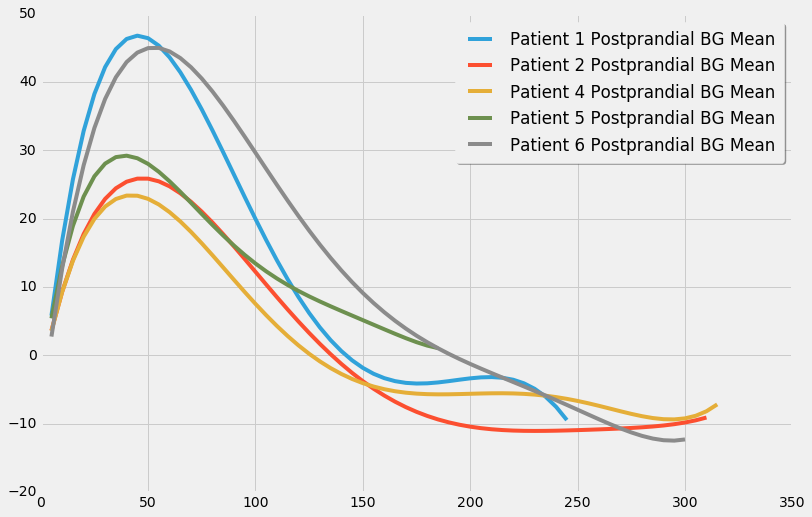

In [522]:
P1_x_All = map(lambda v : v * 5, range(1, len(P1_ALL_Mean)+1, 1))
P2_x_All = map(lambda v : v * 5, range(1, len(P2_ALL_Mean)+1, 1))
P4_x_All = map(lambda v : v * 5, range(1, len(P4_ALL_Mean)+1, 1))
P5_x_All = map(lambda v : v * 5, range(1, len(P5_ALL_Mean)+1, 1))
P6_x_All = map(lambda v : v * 5, range(1, len(P6_ALL_Mean)+1, 1))


plt.figure(figsize=(12,8))

plt.plot(P1_x_All, P1_ALL_Mean , label='Patient 1 Postprandial BG Mean')
plt.plot(P2_x_All, P2_ALL_Mean , label='Patient 2 Postprandial BG Mean')
plt.plot(P4_x_All, P4_ALL_Mean , label='Patient 4 Postprandial BG Mean')
plt.plot(P5_x_All, P5_ALL_Mean , label='Patient 5 Postprandial BG Mean')
plt.plot(P6_x_All, P6_ALL_Mean , label='Patient 6 Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

**Adding the (0,0), only for visualization**

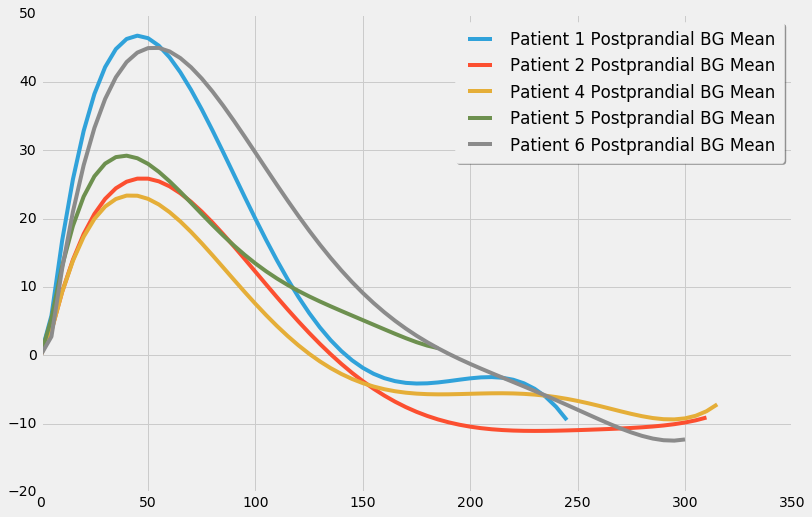

In [523]:
P1_x_All = map(lambda v : v * 5, range(1, len(P1_ALL_Mean)+1, 1))
P2_x_All = map(lambda v : v * 5, range(1, len(P2_ALL_Mean)+1, 1))
P4_x_All = map(lambda v : v * 5, range(1, len(P4_ALL_Mean)+1, 1))
P5_x_All = map(lambda v : v * 5, range(1, len(P5_ALL_Mean)+1, 1))
P6_x_All = map(lambda v : v * 5, range(1, len(P6_ALL_Mean)+1, 1))


plt.figure(figsize=(12,8))

plt.plot([0] + P1_x_All, [0] + P1_ALL_Mean , label='Patient 1 Postprandial BG Mean')
plt.plot([0] + P2_x_All, [0] + P2_ALL_Mean , label='Patient 2 Postprandial BG Mean')
plt.plot([0] + P4_x_All, [0] + P4_ALL_Mean , label='Patient 4 Postprandial BG Mean')
plt.plot([0] + P5_x_All, [0] + P5_ALL_Mean , label='Patient 5 Postprandial BG Mean')
plt.plot([0] + P6_x_All, [0] + P6_ALL_Mean , label='Patient 6 Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

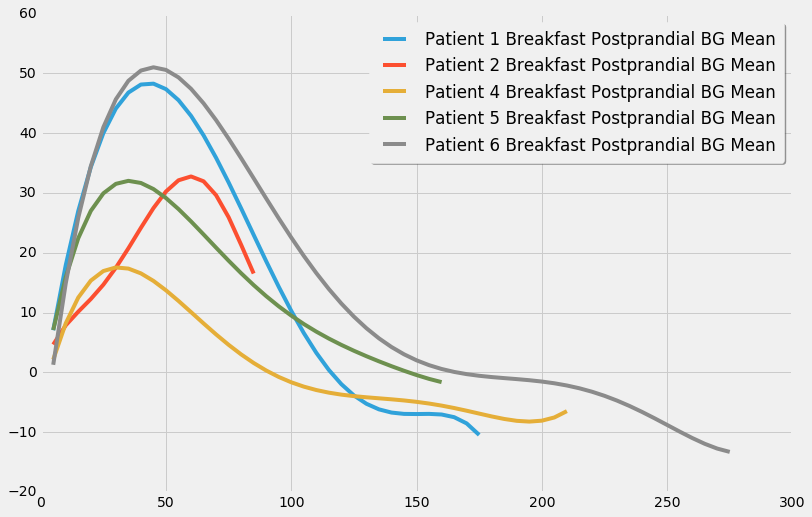

In [524]:
P1_x_Breakfast = map(lambda v : v * 5, range(1, len(P1_Breakfast_Mean)+1, 1))
P2_x_Breakfast = map(lambda v : v * 5, range(1, len(P2_Breakfast_Mean)+1, 1))
P4_x_Breakfast = map(lambda v : v * 5, range(1, len(P4_Breakfast_Mean)+1, 1))
P5_x_Breakfast = map(lambda v : v * 5, range(1, len(P5_Breakfast_Mean)+1, 1))
P6_x_Breakfast = map(lambda v : v * 5, range(1, len(P6_Breakfast_Mean)+1, 1))

plt.figure(figsize=(12,8))

plt.plot(P1_x_Breakfast, P1_Breakfast_Mean , label='Patient 1 Breakfast Postprandial BG Mean')
plt.plot(P2_x_Breakfast, P2_Breakfast_Mean , label='Patient 2 Breakfast Postprandial BG Mean')
plt.plot(P4_x_Breakfast, P4_Breakfast_Mean , label='Patient 4 Breakfast Postprandial BG Mean')
plt.plot(P5_x_Breakfast, P5_Breakfast_Mean , label='Patient 5 Breakfast Postprandial BG Mean')
plt.plot(P6_x_Breakfast, P6_Breakfast_Mean , label='Patient 6 Breakfast Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

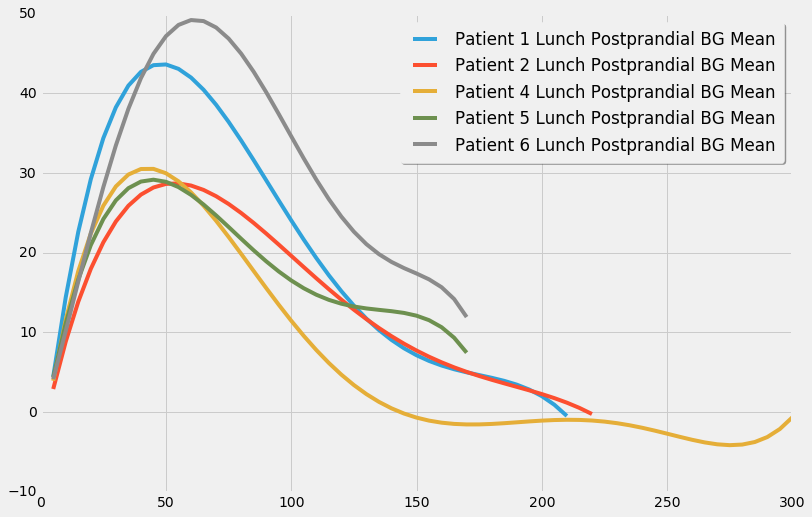

In [525]:
P1_x_Lunch = map(lambda v : v * 5, range(1, len(P1_Lunch_Mean)+1, 1))
P2_x_Lunch = map(lambda v : v * 5, range(1, len(P2_Lunch_Mean)+1, 1))
P4_x_Lunch = map(lambda v : v * 5, range(1, len(P4_Lunch_Mean)+1, 1))
P5_x_Lunch = map(lambda v : v * 5, range(1, len(P5_Lunch_Mean)+1, 1))
P6_x_Lunch = map(lambda v : v * 5, range(1, len(P6_Lunch_Mean)+1, 1))


plt.figure(figsize=(12,8))

plt.plot(P1_x_Lunch, P1_Lunch_Mean , label='Patient 1 Lunch Postprandial BG Mean')
plt.plot(P2_x_Lunch, P2_Lunch_Mean , label='Patient 2 Lunch Postprandial BG Mean')
plt.plot(P4_x_Lunch, P4_Lunch_Mean , label='Patient 4 Lunch Postprandial BG Mean')
plt.plot(P5_x_Lunch, P5_Lunch_Mean , label='Patient 5 Lunch Postprandial BG Mean')
plt.plot(P6_x_Lunch, P6_Lunch_Mean , label='Patient 6 Lunch Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

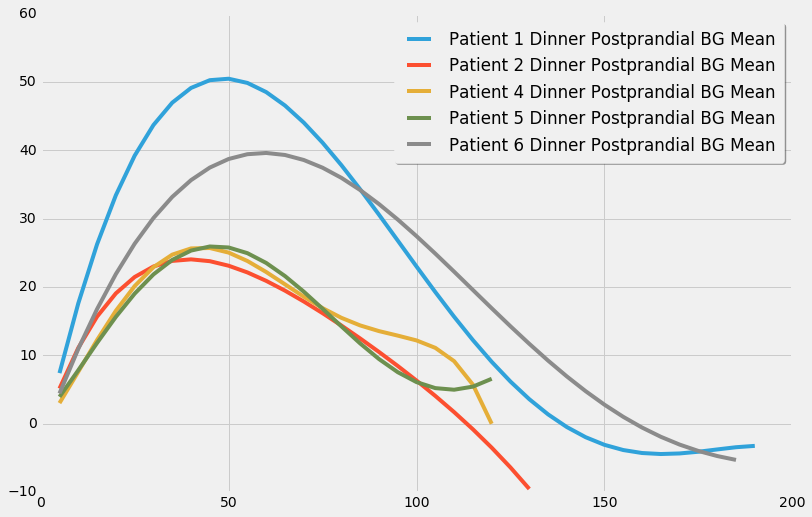

In [526]:
P1_x_Dinner = map(lambda v : v * 5, range(1, len(P1_Dinner_Mean)+1, 1))
P2_x_Dinner = map(lambda v : v * 5, range(1, len(P2_Dinner_Mean)+1, 1))
P4_x_Dinner = map(lambda v : v * 5, range(1, len(P4_Dinner_Mean)+1, 1))
P5_x_Dinner = map(lambda v : v * 5, range(1, len(P5_Dinner_Mean)+1, 1))
P6_x_Dinner = map(lambda v : v * 5, range(1, len(P6_Dinner_Mean)+1, 1))


plt.figure(figsize=(12,8))

plt.plot(P1_x_Dinner, P1_Dinner_Mean , label='Patient 1 Dinner Postprandial BG Mean')
plt.plot(P2_x_Dinner, P2_Dinner_Mean , label='Patient 2 Dinner Postprandial BG Mean')
plt.plot(P4_x_Dinner, P4_Dinner_Mean , label='Patient 4 Dinner Postprandial BG Mean')
plt.plot(P5_x_Dinner, P5_Dinner_Mean , label='Patient 5 Dinner Postprandial BG Mean')
plt.plot(P6_x_Dinner, P6_Dinner_Mean , label='Patient 6 Dinner Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

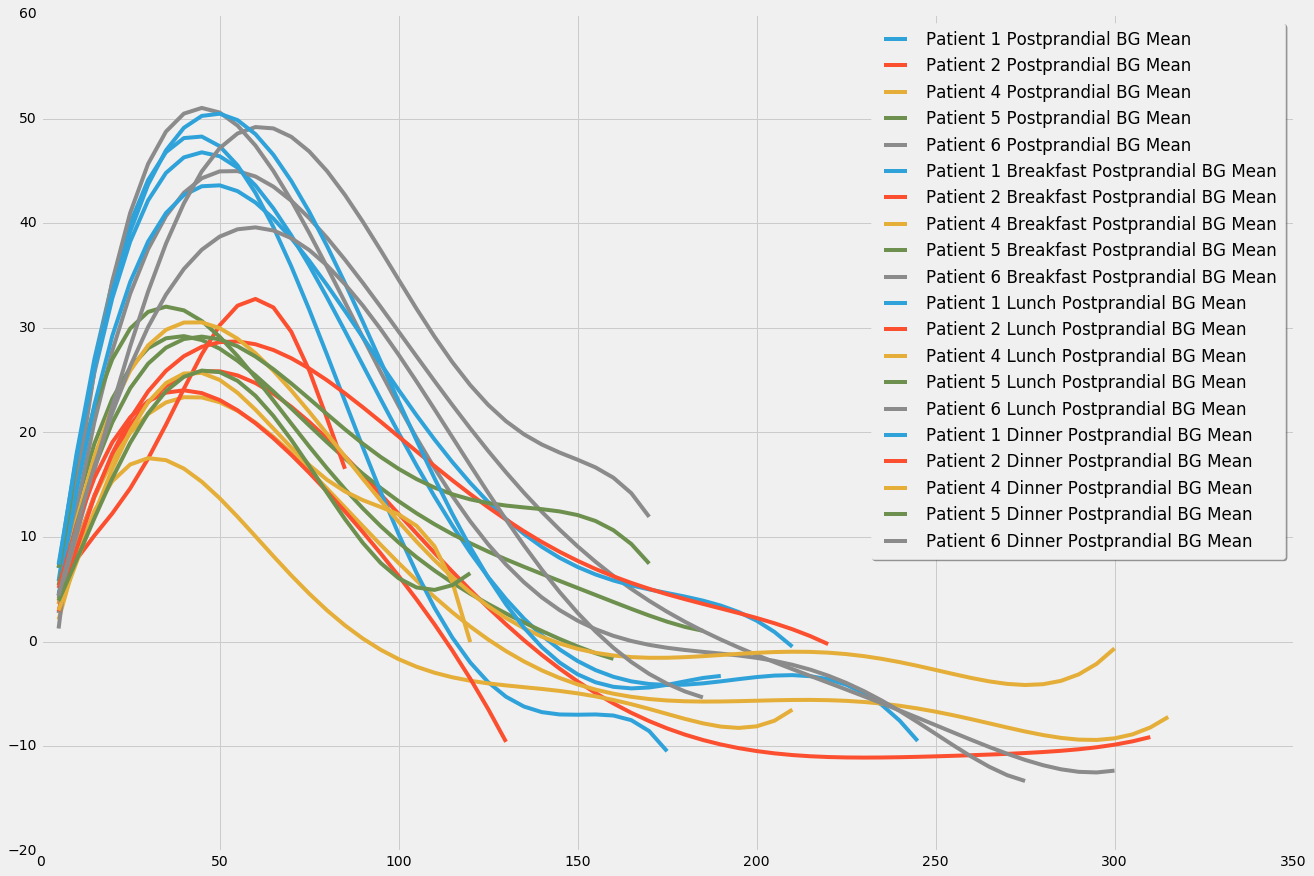

In [527]:
plt.figure(figsize=(20,14))

plt.plot(P1_x_All, P1_ALL_Mean , label='Patient 1 Postprandial BG Mean')
plt.plot(P2_x_All, P2_ALL_Mean , label='Patient 2 Postprandial BG Mean')
plt.plot(P4_x_All, P4_ALL_Mean , label='Patient 4 Postprandial BG Mean')
plt.plot(P5_x_All, P5_ALL_Mean , label='Patient 5 Postprandial BG Mean')
plt.plot(P6_x_All, P6_ALL_Mean , label='Patient 6 Postprandial BG Mean')

plt.plot(P1_x_Breakfast, P1_Breakfast_Mean , label='Patient 1 Breakfast Postprandial BG Mean')
plt.plot(P2_x_Breakfast, P2_Breakfast_Mean , label='Patient 2 Breakfast Postprandial BG Mean')
plt.plot(P4_x_Breakfast, P4_Breakfast_Mean , label='Patient 4 Breakfast Postprandial BG Mean')
plt.plot(P5_x_Breakfast, P5_Breakfast_Mean , label='Patient 5 Breakfast Postprandial BG Mean')
plt.plot(P6_x_Breakfast, P6_Breakfast_Mean , label='Patient 6 Breakfast Postprandial BG Mean')

plt.plot(P1_x_Lunch, P1_Lunch_Mean , label='Patient 1 Lunch Postprandial BG Mean')
plt.plot(P2_x_Lunch, P2_Lunch_Mean , label='Patient 2 Lunch Postprandial BG Mean')
plt.plot(P4_x_Lunch, P4_Lunch_Mean , label='Patient 4 Lunch Postprandial BG Mean')
plt.plot(P5_x_Lunch, P5_Lunch_Mean , label='Patient 5 Lunch Postprandial BG Mean')
plt.plot(P6_x_Lunch, P6_Lunch_Mean , label='Patient 6 Lunch Postprandial BG Mean')

plt.plot(P1_x_Dinner, P1_Dinner_Mean , label='Patient 1 Dinner Postprandial BG Mean')
plt.plot(P2_x_Dinner, P2_Dinner_Mean , label='Patient 2 Dinner Postprandial BG Mean')
plt.plot(P4_x_Dinner, P4_Dinner_Mean , label='Patient 4 Dinner Postprandial BG Mean')
plt.plot(P5_x_Dinner, P5_Dinner_Mean , label='Patient 5 Dinner Postprandial BG Mean')
plt.plot(P6_x_Dinner, P6_Dinner_Mean , label='Patient 6 Dinner Postprandial BG Mean')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

**From above, we are selecting Patient 6 Breakfast postprandial BG signal as Initial Generic Plot because it is the most different than all the rest, we will see if it can adapt and converge to other signals**


**As first example, we are picking Patient 4 postprandial BG signal as desired output**

Plotting the two against each other...

32


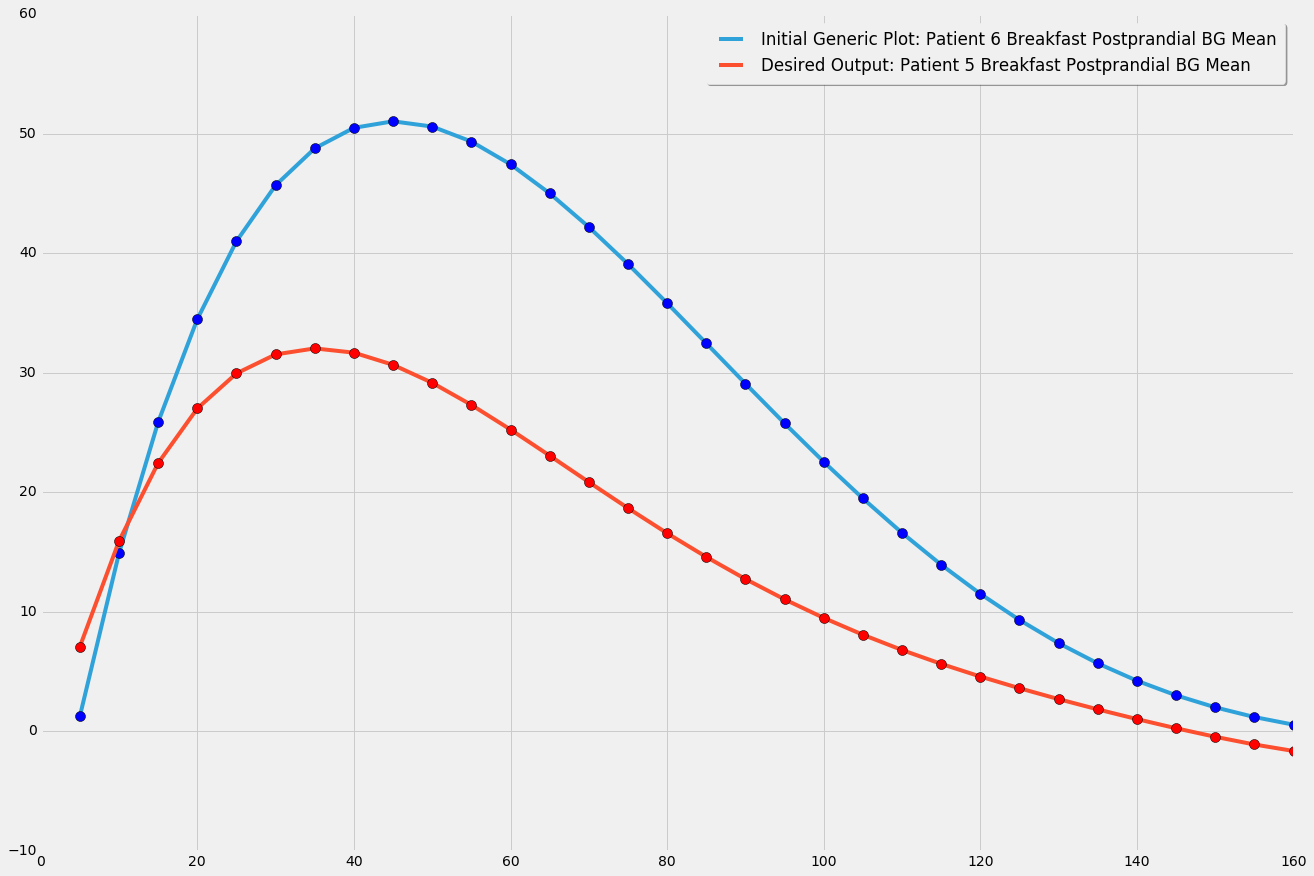

In [528]:
#x_window = map(lambda v : v * 5, range(1, 48+1, 1))#Max window is 4 hours(240 minutes)
x_window = map(lambda v : v * 5, range(1, 32+1, 1))#Max window is 4 hours(240 minutes)

print len(P5_Breakfast_Mean)

plt.figure(figsize=(20,14))

initial_plot = P6_Breakfast_Mean[:len(x_window)]
desired_outcome = P5_Breakfast_Mean[:len(x_window)]

plt.plot(x_window, initial_plot, label='Initial Generic Plot: Patient 6 Breakfast Postprandial BG Mean')
plt.plot(x_window, initial_plot , 'bo', markersize = 10, label='')

plt.plot(x_window, desired_outcome , label='Desired Output: Patient 5 Breakfast Postprandial BG Mean')
plt.plot(x_window, desired_outcome , 'ro', markersize = 10, label='')

plt.legend(shadow=True, borderpad=0.5)
plt.show()

Step 3: Add points of every 15 minutes from the test signal to our intial plot, average them

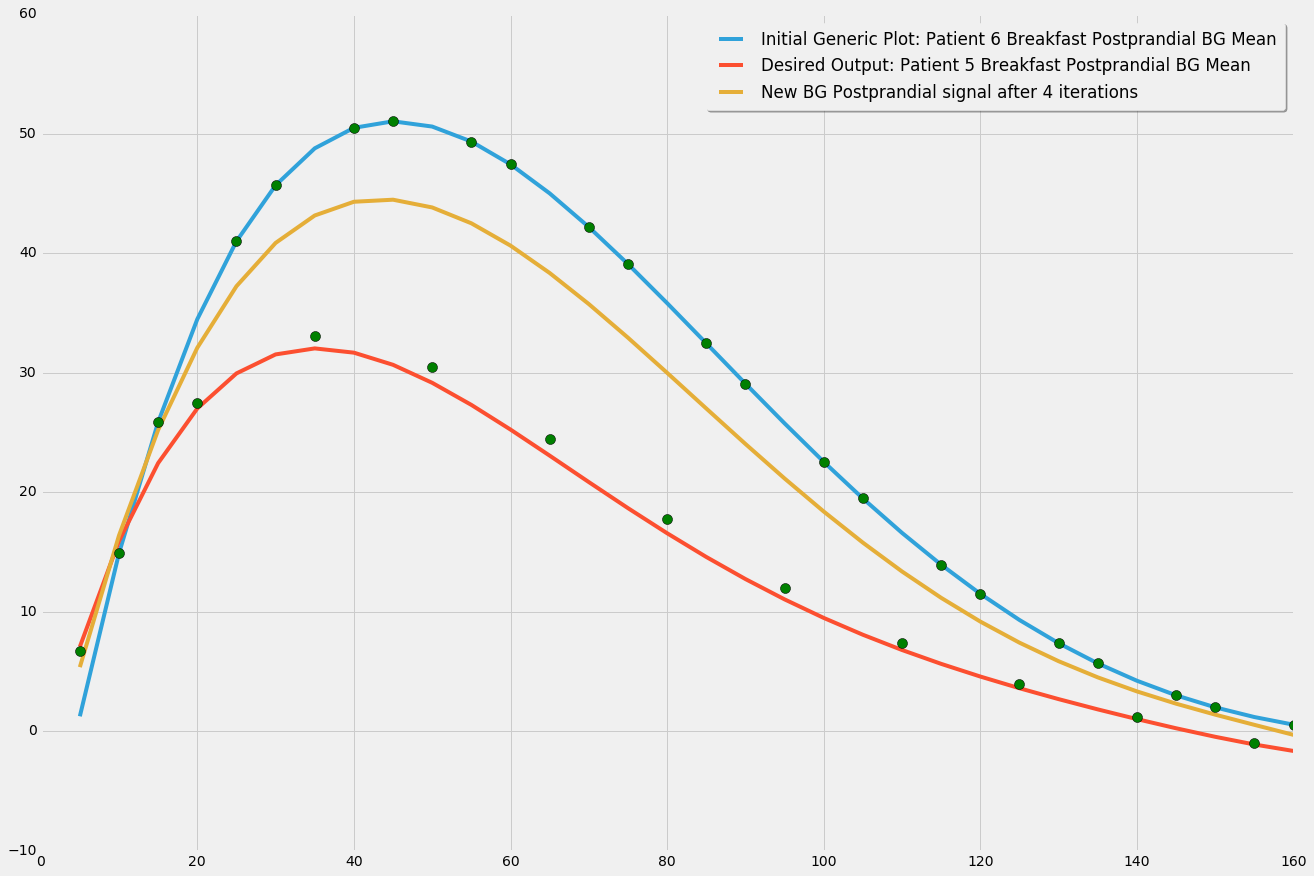

In [529]:
j = 0

new_initial_plot = []
new_initial_plot = [float(i) for i in initial_plot]
#print type(new_initial_plot)

while(j<4):#number of iterations, equivalent to number of days
    for i, bg_point in enumerate(new_initial_plot):
        if (i % 3 == 0):
            new_initial_plot[i] = (float(desired_outcome[i]) + bg_point)/2            
    j +=1
    
#print new_initial_plot
    
p = np.poly1d(np.polyfit(x_window, new_initial_plot, deg=5))  

    
plt.figure(figsize=(20,14))

plt.plot(x_window, initial_plot, label='Initial Generic Plot: Patient 6 Breakfast Postprandial BG Mean')
#plt.plot(x_window, initial_plot , 'bo', markersize = 10, label='')

plt.plot(x_window, desired_outcome , label='Desired Output: Patient 5 Breakfast Postprandial BG Mean')
#plt.plot(x_window, desired_outcome , 'ro', markersize = 10, label='')

plt.plot(x_window, p(x_window) , label='New BG Postprandial signal after {} iterations'.format(j))
plt.plot(x_window, new_initial_plot , 'go', markersize = 10, label='')

plt.legend(shadow=True, borderpad=0.5)
plt.show()    

**Conclusion: Adding points at the same time instance will not allow adequate convergence; therefore, patient must provide BG at different time instances**

**Adding a single point at a time. It has been changed to account for any number of inputs at same postprandial period**

Below cell is with 5 minutes increments

32

The result after 30 days with 3 BG input readings everyday:



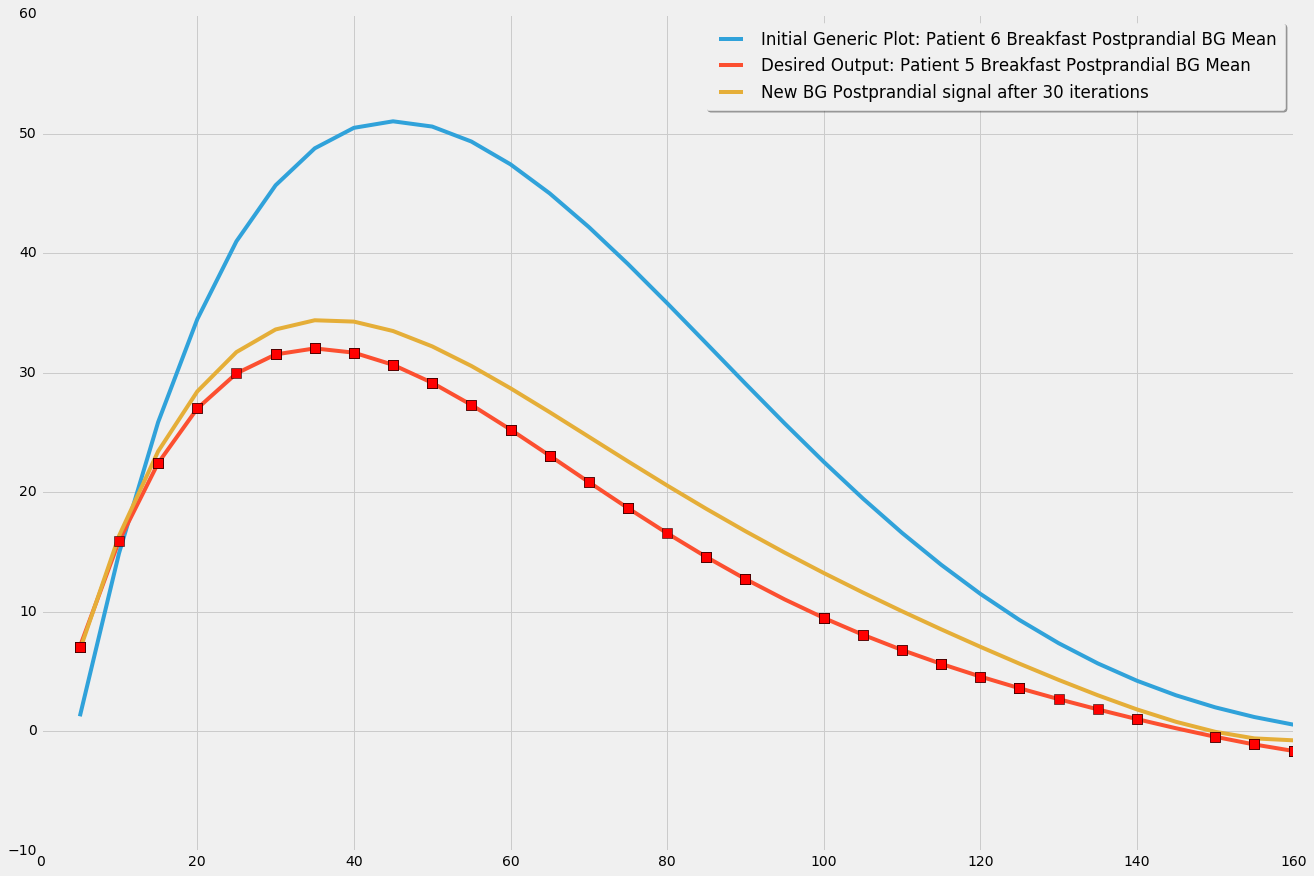

In [574]:
from random import randint
j = 0
days = 30
k = 3#number of inputs every time

new_initial_plot = []
new_initial_plot = [float(i) for i in initial_plot]
print len(new_initial_plot)
#print type(new_initial_plot)

N_arr = []
Y_points = []
fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(1,1,1)

while(j<days):#number of iterations, equivalent to number of days

    for i in range(k):    
        N = randint(1, len(new_initial_plot))
        #print N
        N_arr.extend([N * 5])
        BG_input = desired_outcome[N-1]# we add -1 here because those arrays start at 5 minutes instead of 0 minutes
        Y_points.extend([BG_input])
        new_initial_plot[N-1] = (float(BG_input) + new_initial_plot[N-1])/2            

    j +=1
    
print "\nThe result after {} days with".format(days), "{}".format(k), "BG input readings everyday:\n"

p = np.poly1d(np.polyfit(x_window, new_initial_plot, deg=5))  

ax.plot(x_window, initial_plot, label='Initial Generic Plot: Patient 6 Breakfast Postprandial BG Mean')
#ax.plot(x_window, initial_plot , 'bo', markersize = 10, label='')

ax.plot(x_window, desired_outcome , label='Desired Output: Patient 5 Breakfast Postprandial BG Mean')
#ax.plot(x_window, desired_outcome , 'ro', markersize = 10, label='')

ax.plot(x_window, p(x_window) , label='New BG Postprandial signal after {} iterations'.format(j))
#ax.plot(x_window, new_initial_plot , 'go', markersize = 10, label='')


ax.plot(N_arr, Y_points , 'rs', markersize = 10, label='')

ax.legend(shadow=True, borderpad=0.5)
plt.show()


Below cell is with minutes increment as a variable

8
8
8
11
6
7
6
7
8
1
1
11
2
8
5
5
1
8
6
11

The result after 10 days with 2 BG input readings everyday:



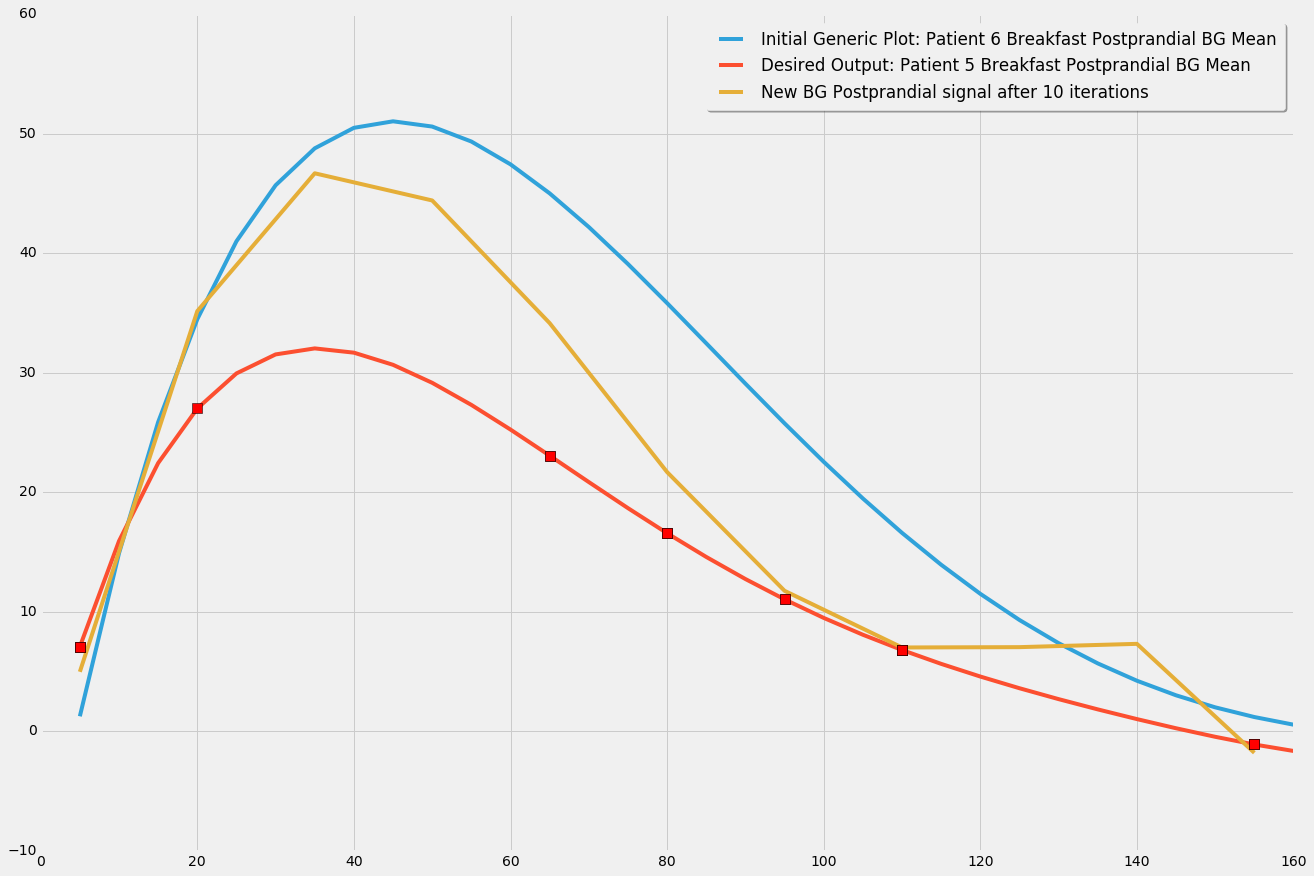


The total input readings are 20 at the following minutes:
[110, 110, 110, 155, 80, 95, 80, 95, 110, 5, 5, 155, 20, 110, 65, 65, 5, 110, 80, 155]


In [556]:
import random
#from random import randint
from datetime import datetime
random.seed()

j = 0
minutes_incr = 3 # increments, 3*5 so 15 minutes increments
days = 10
k = 2#number of inputs every time

N_arr = []
Y_points = []
new_initial_plot = []
new_initial_plot = [float(item) for i, item in enumerate(initial_plot) if (i%minutes_incr == 0)]# 2 signifies readings every 10 minutes
new_desired_outcome = [float(item) for i, item in enumerate(desired_outcome) if (i%minutes_incr == 0)]

#print len(new_initial_plot)
new_x_window = map(lambda v :  5+ (v *5 * minutes_incr), range(0, len(new_initial_plot), 1))

p_new = np.poly1d(np.polyfit(new_x_window, new_desired_outcome, deg=5))  


fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(1,1,1)

while(j<days):#number of iterations, equivalent to number of days
    for i in range(k):    
        N = randint(1, len(new_initial_plot))
        print N
        N_arr.extend([((N-1) * minutes_incr *5 )+ 5])
        BG_input = new_desired_outcome[N-1]# we add -1 here because those arrays start at 5 minutes instead of 0 minutes
        Y_points.extend([BG_input])
        new_initial_plot[N-1] = (float(BG_input) + new_initial_plot[N-1])/2            
        
    j +=1
    
print "\nThe result after {} days with".format(days), "{}".format(k), "BG input readings everyday:\n"

p = np.poly1d(np.polyfit(new_x_window, new_initial_plot, deg=5))  

ax.plot(x_window, initial_plot, label='Initial Generic Plot: Patient 6 Breakfast Postprandial BG Mean')
#ax.plot(x_window, initial_plot , 'bo', markersize = 10, label='')

ax.plot(x_window, desired_outcome , label='Desired Output: Patient 5 Breakfast Postprandial BG Mean')
#ax.plot(x_window, desired_outcome , 'ro', markersize = 10, label='')
#ax.plot(new_x_window, p_new(new_x_window) , label='New Desired Output: Curve fit using {} minutes iterations'.format(minutes_incr*5))
#ax.plot(new_x_window, p_new(new_x_window) , 'yo', markersize = 10, label='')

ax.plot(new_x_window, p(new_x_window) , label='New BG Postprandial signal after {} iterations'.format(j))
#ax.plot(new_x_window, new_initial_plot , 'go', markersize = 10, label='')

ax.plot(N_arr, Y_points , 'rs', markersize = 10, label='')

ax.legend(shadow=True, borderpad=0.5)
plt.show()

print "\nThe total input readings are", len(N_arr), "at the following minutes:\n", N_arr

Update the initial plot with recorded BG readings from various postprandial signals of the same period, compare result to the mean of that period.

[3.0, 29.0, 14.0, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Selected reading is: nan which occurs at 65 minute of 17 th signal.
[0.0, 38.0, 45.0, 20.0, 9.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Selected reading is: 9.0 which occurs at 65 minute of 2 th signal.
[0.0, 6.0, 59.0, 71.0, 41.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Selected reading is: nan which occurs at 80 minute of 18 th signal.
[5.0, 21.0, 39.0, 10.0, -3.0, -11.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Selected reading is: -11.0 which occurs at 80 minute of 0 th signal.
[2.0, 5.0, 26.0, 17.0, 9.0, -4.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Selected reading is: -4.0 which occurs at 80 minute of 15 th signal.
[0.0, 38.0, 45.0, 20.0, 9.0, nan, nan

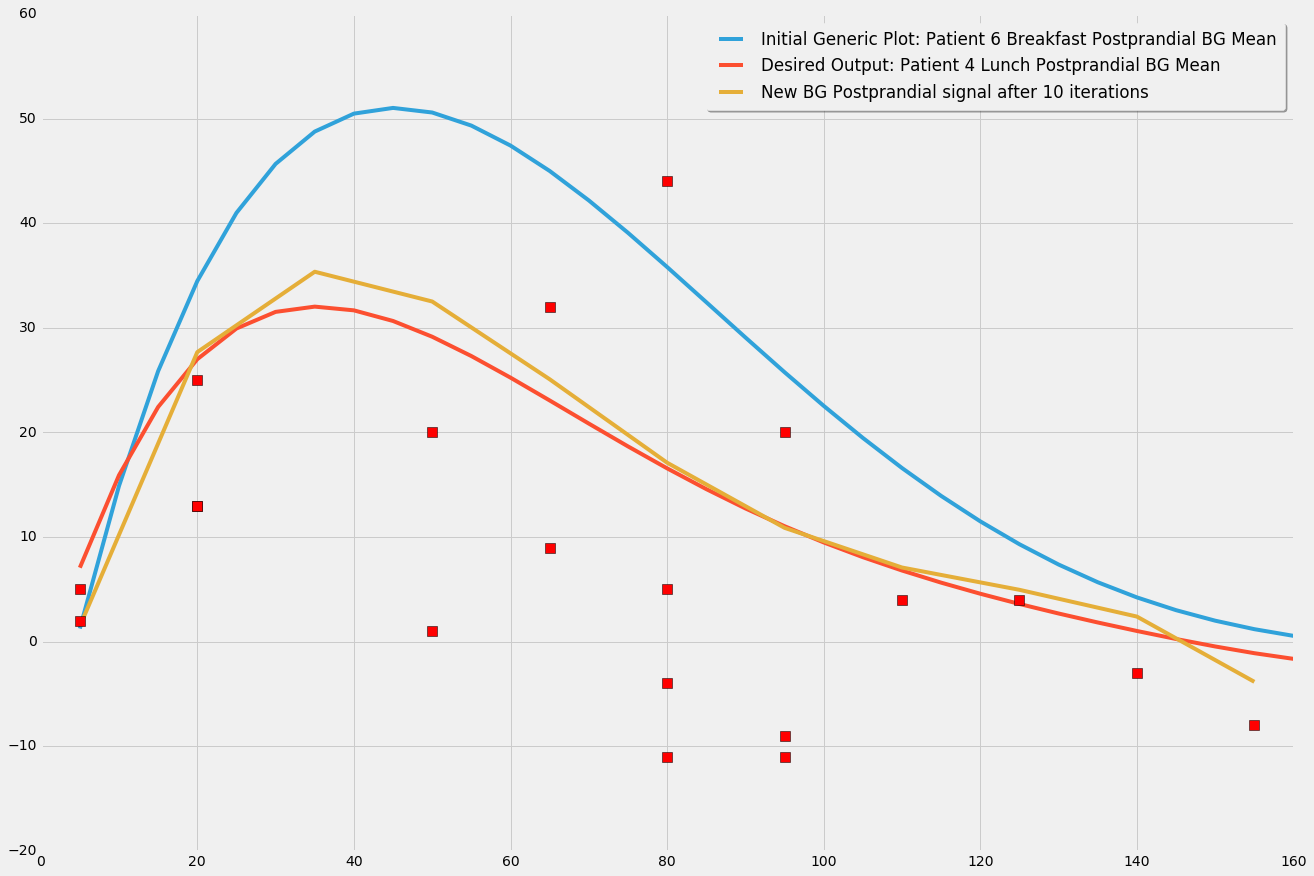


The total input readings are 20 at the following minutes:
[65, 80, 80, 50, 80, 50, 95, 20, 5, 65, 140, 95, 80, 110, 155, 20, 20, 5, 125, 95]


In [566]:
import random
#from random import randint
from datetime import datetime
random.seed()

j = 0
minutes_incr = 3 # increments, 3*5 so 15 minutes increments
days = 10
k = 2#number of inputs every time

N_arr = []
Y_points = []
new_initial_plot = []
new_initial_plot = [float(item) for i, item in enumerate(initial_plot) if (i%minutes_incr == 0)]# 2 signifies readings every 10 minutes
new_desired_outcome = [float(item) for i, item in enumerate(desired_outcome) if (i%minutes_incr == 0)]



#select a BG readings from the saved postprandial file:
#1. select randomly a row, then select a reading from that row

desired_outcome_df_signals= pd.read_csv('P5_breakfast_postprandial.csv')
#print desired_outcome_df_signals
        
    
#print len(new_initial_plot)
new_x_window = map(lambda v :  5 + (v *5 * minutes_incr), range(0, len(new_initial_plot), 1))

p_new = np.poly1d(np.polyfit(new_x_window, new_desired_outcome, deg=5))  


fig = plt.figure(figsize=(20,14))
ax = fig.add_subplot(1,1,1)

while(j<days):#number of iterations, equivalent to number of days
    for i in range(k):    
        N = randint(1, len(new_initial_plot))
        #print N
        N_arr.extend([((N-1) * minutes_incr *5 )+ 5])
               
       
        #############
        Bg_input_bool = False
        #select randomly a row, then select a reading from that row
       
        while(Bg_input_bool == False):
            N2 = randint(0, (desired_outcome_df_signals.shape[0] -1))
 
            selected_singal = [float(item) for i, item in enumerate(desired_outcome_df_signals.iloc[N2,1:]) if (i%minutes_incr == 0)]
            print selected_singal
            
            print "Selected reading is:", selected_singal[N-1], "which occurs at", (((N-1) * minutes_incr *5 )+ 5), "minute of", N2, "th signal."
            Bg_input_value = selected_singal[N-1]
            if (~np.isnan(Bg_input_value)):
                Bg_input_bool = True
        #print "input is:"  , BG_input2
        
        
        
        BG_input = Bg_input_value# we add -1 here because those arrays start at 5 minutes instead of 0 minutes
        Y_points.extend([BG_input])
        new_initial_plot[N-1] = (float(BG_input) + new_initial_plot[N-1])/2            
        
    j +=1
    
print "\nThe result after {} days with".format(days), "{}".format(k), "BG input readings everyday:\n"

p = np.poly1d(np.polyfit(new_x_window, new_initial_plot, deg=5))  

ax.plot(x_window, initial_plot, label='Initial Generic Plot: Patient 6 Breakfast Postprandial BG Mean')
#ax.plot(x_window, initial_plot , 'bo', markersize = 10, label='')

ax.plot(x_window, desired_outcome , label='Desired Output: Patient 5 Breakfast Postprandial BG Mean')
#ax.plot(x_window, desired_outcome , 'ro', markersize = 10, label='')
#ax.plot(new_x_window, p_new(new_x_window) , label='New Desired Output: Curve fit using {} minutes iterations'.format(minutes_incr*5))
#ax.plot(new_x_window, p_new(new_x_window) , 'yo', markersize = 10, label='')

ax.plot(new_x_window, p(new_x_window) , label='New BG Postprandial signal after {} iterations'.format(j))
#ax.plot(new_x_window, new_initial_plot , 'go', markersize = 10, label='')

ax.plot(N_arr, Y_points , 'rs', markersize = 10, label='')

ax.legend(shadow=True, borderpad=0.5)
plt.show()

print "\nThe total input readings are", len(N_arr), "at the following minutes:\n", N_arr